In [3]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [4]:
freq = input('Qual a categoria dos dados de energia para a previsão? \nD -> Total gerado por dia \nH -> Total gerado por hora\n')
altera_param = input('Deseja realizar análise do dropout com alteração de parâmetros? [y/n] \n')

if altera_param == 'y':
  parameter = int(input('Quais parâmetros deseja alterar? \n 1 -> length scale (l) \n 2 -> Probabilidade de dropout (p) \n 3 -> Peso da regularização L2 (lbd)\n'))

Qual a categoria dos dados de energia para a previsão? 
D -> Total gerado por dia 
H -> Total gerado por hora
D
Deseja realizar análise do dropout com alteração de parâmetros? [y/n] 
n


##Importação dos dados

###Dados de Energia

In [5]:
data_hourly = read_csv('Dados_FV_2018_2021.csv',sep=',', decimal='.')
data_hourly

,Data e horário,Corrente CA L1|Primo 3.0-1 (# 1),Corrente CC MPP1|Primo 3.0-1 (# 1),Energia|Primo 3.0-1 (# 1),Potência aparente|Primo 3.0-1 (# 1),Voltagem CA L1|Primo 3.0-1 (# 1),Voltagem CC MPP1|Primo 3.0-1 (# 1),Produção fotovoltaica
0,[dd.MM.yyyy HH:mm],[A],[A],[Wh],[VA],[V],[V],[Wh]
1,01.08.2018 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01.08.2018 00:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01.08.2018 00:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01.08.2018 00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
265010,24.02.2021 17:00,"0,04","0,04",0,"4,18","218,9",278,0
265011,24.02.2021 17:05,0,0,0,0,0,"233,4",0
265012,24.02.2021 17:10,0,0,0,0,0,"215,3",0
265013,24.02.2021 17:15,0,0,0,0,0,"185,54",0


In [6]:
data_hourly.drop(['Corrente CA L1|Primo 3.0-1 (# 1)',  'Corrente CC MPP1|Primo 3.0-1 (# 1)',
         'Produção fotovoltaica',	'Potência aparente|Primo 3.0-1 (# 1)',
         'Voltagem CA L1|Primo 3.0-1 (# 1)',	'Voltagem CC MPP1|Primo 3.0-1 (# 1)'],axis=1,inplace=True)
data_hourly.rename(columns={'Energia|Primo 3.0-1 (# 1)':'Energia'},inplace=True)
data_hourly.drop(index=0,inplace=True)
data_hourly.dropna(axis=0,inplace=True) # Eliminar os dados NaN
data_hourly

,Data e horário,Energia
14,01.08.2018 01:05,0
65,01.08.2018 05:20,0
66,01.08.2018 05:25,0
67,01.08.2018 05:30,0
68,01.08.2018 05:35,0
...,...,...
265010,24.02.2021 17:00,0
265011,24.02.2021 17:05,0
265012,24.02.2021 17:10,0
265013,24.02.2021 17:15,0


In [7]:
#Converter as colunas de tempo para o formato datetime
data_hourly['TEMPO'] = pd.to_datetime(data_hourly['Data e horário'],dayfirst=True)
data_hourly.drop('Data e horário',axis=1,inplace=True)
data_hourly.set_index('TEMPO',inplace=True) #Configurar as datas como index

#Converter para float
data_hourly['Energia'] = data_hourly['Energia'].str.replace(',','.').astype(float)
data_hourly.head(30)

,Energia
TEMPO,
2018-08-01 01:05:00,0.00
2018-08-01 05:20:00,0.00
2018-08-01 05:25:00,0.00
2018-08-01 05:30:00,0.00
2018-08-01 05:35:00,0.00
2018-08-01 05:40:00,0.00
2018-08-01 05:45:00,0.00
2018-08-01 05:50:00,0.01
2018-08-01 05:55:00,0.96


In [8]:
#maxima_semanal = data_hourly.groupby(pd.Grouper(freq='W')).max()
#maxima_diaria = data_hourly.groupby(pd.Grouper(freq='D')).max()

#Como as datas que são agrupadas são índices do DataFrame, utiliza-se o resample

maxima_semanal = data_hourly.resample('W').sum()
maxima_diaria = data_hourly.resample('D').sum()
maxima_hora = data_hourly.resample('H').sum()


In [9]:
#maxima_diaria.dropna(axis=0,inplace=True)
maxima_hora

,Energia
TEMPO,
2018-08-01 01:00:00,0.00
2018-08-01 02:00:00,0.00
2018-08-01 03:00:00,0.00
2018-08-01 04:00:00,0.00
2018-08-01 05:00:00,0.97
...,...
2021-02-24 13:00:00,1679.89
2021-02-24 14:00:00,1104.89
2021-02-24 15:00:00,481.93


In [10]:
# from google.colab import files
# maxima_hora.reset_index(inplace=True)
# maxima_hora.to_csv('dados_FV_serra_negra.csv',sep=',')
# files.download('dados_FV_serra_negra.csv')

###Plots Diversos

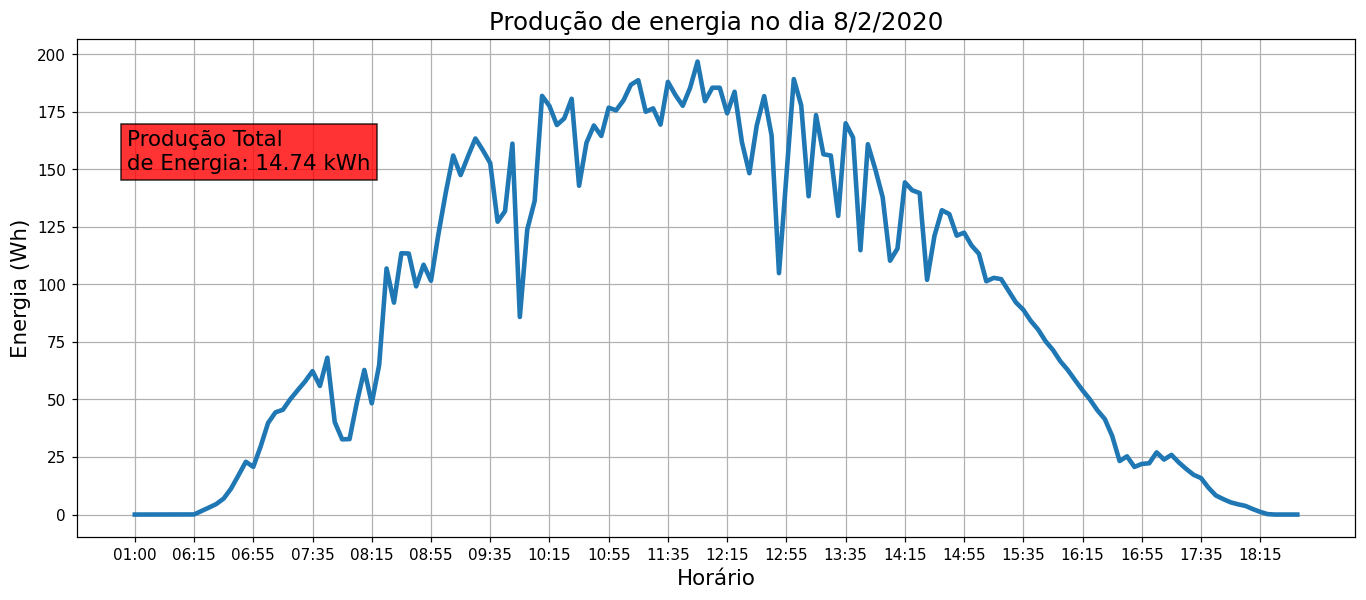

14737.900000000001


In [11]:
from datetime import datetime
dia = 8
mes = 2
ano = 2020

start = data_hourly.index.searchsorted(datetime(ano, mes, dia))
end = data_hourly.index.searchsorted(datetime(ano, mes, dia+1))
aux = data_hourly.iloc[start:end]

energia_diaria = aux['Energia']
hr = np.array(aux.index.time)
hr = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

fig = plt.figure(figsize=(15,6),dpi=110)
plt.plot(hr,energia_diaria,lw=3)
plt.xticks(np.arange(0, len(hr)+1, 8))
plt.title('Produção de energia no dia {0}/{1}/{2}'.format(dia,mes,ano),fontsize = 16)
plt.ylabel('Energia (Wh)',fontsize = 14)
plt.xlabel('Horário',fontsize = 14)
plt.text(-1,150,'Produção Total \nde Energia: {0} kWh'.format(round(energia_diaria.sum()/1e3,2)),
        fontsize = 14, bbox = dict(facecolor = 'red', alpha = 0.8))
plt.grid()
plt.show()

print(energia_diaria.sum())


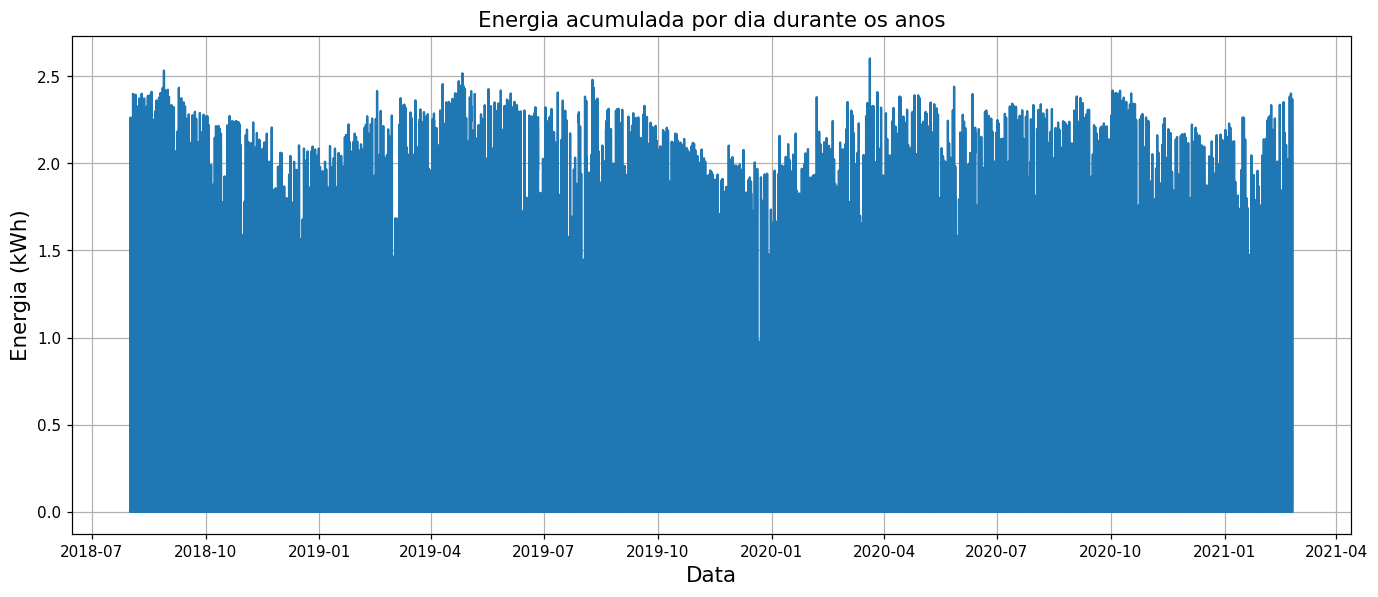

In [12]:

plt.figure(figsize=(15,6),dpi=110)
plt.plot(maxima_hora/1e3)
plt.title('Energia acumulada por dia durante os anos',fontsize = 14)
plt.ylabel('Energia (kWh)',fontsize = 14)
plt.xlabel('Data',fontsize = 14)
plt.grid()
plt.show()

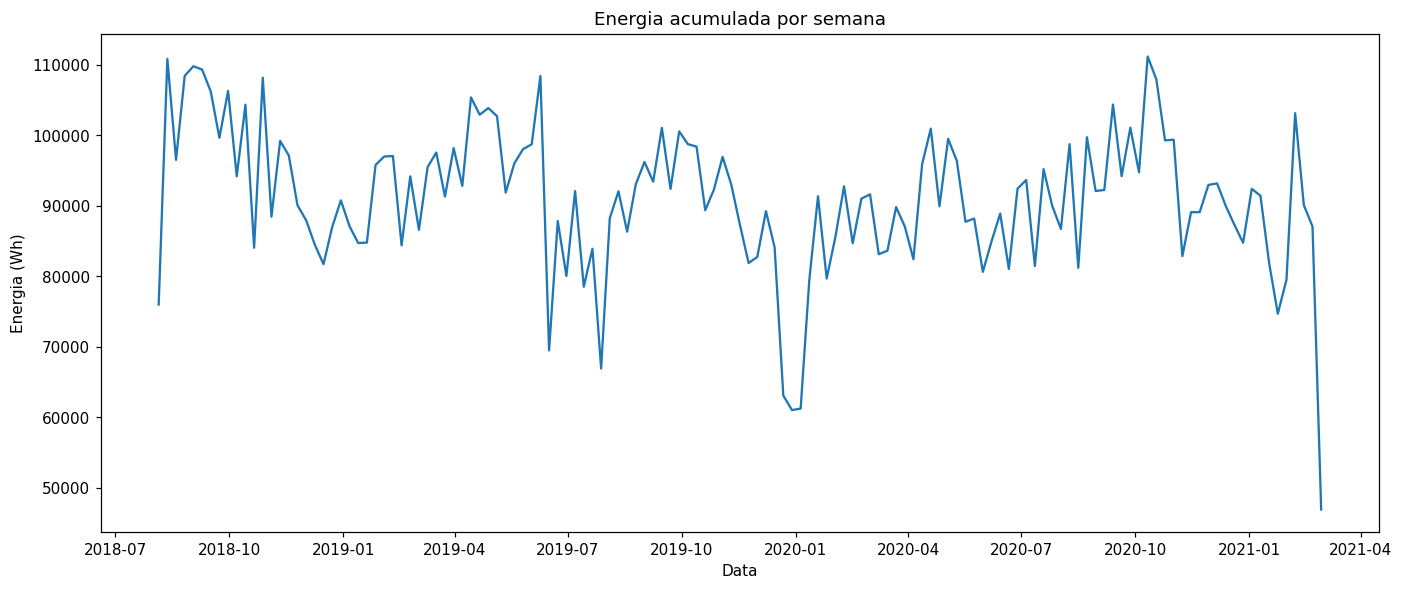

In [13]:
plt.figure(figsize=(15,6),dpi=110)
plt.plot(maxima_semanal)
plt.title('Energia acumulada por semana')
plt.ylabel('Energia (Wh)')
plt.xlabel('Data')
plt.show()

###Dados de clima da NASA

In [14]:
data_hourly_nasa = pd.read_csv('dados_clima_2018_2021.csv', sep=',', on_bad_lines='skip',header=0)
data_hourly_nasa

,YEAR,MO,DY,HR,ALLSKY_KT,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DWN,SZA,T2M,PRECTOTCORR,RH2M,WS10M,WD10M
0,2018,8,1,0,-999.0,0.0,0.0,-999.0,24.53,0.00,71.69,5.25,104.84
1,2018,8,1,1,-999.0,0.0,0.0,-999.0,24.13,0.00,73.38,4.83,112.04
2,2018,8,1,2,-999.0,0.0,0.0,-999.0,23.84,0.00,74.44,4.50,119.05
3,2018,8,1,3,-999.0,0.0,0.0,-999.0,23.64,0.00,75.12,4.35,124.09
4,2018,8,1,4,-999.0,0.0,0.0,-999.0,23.49,0.00,75.56,4.35,126.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22531,2021,2,24,19,-999.0,0.0,0.0,-999.0,27.05,0.17,75.19,2.44,30.84
22532,2021,2,24,20,-999.0,0.0,0.0,-999.0,26.53,0.11,76.75,2.61,41.96
22533,2021,2,24,21,-999.0,0.0,0.0,-999.0,25.94,0.14,78.62,3.01,54.95
22534,2021,2,24,22,-999.0,0.0,0.0,-999.0,25.37,0.12,81.25,3.54,65.64


In [15]:
#Converter as colunas de tempo para o formato datetime
data_hourly_nasa.drop([0],inplace=True)
data_hourly_nasa['DATA'] = data_hourly_nasa[['DY','MO','YEAR','HR']].apply(lambda x : datetime(year=x[2],month=x[1],day=x[0],hour=x[3]), axis=1)
data_hourly_nasa.drop(['DY','MO','YEAR','HR'],axis=1,inplace=True)

data_hourly_nasa.set_index('DATA',inplace=True) #Configurar as datas como index


In [16]:
data_hourly_nasa

,ALLSKY_KT,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DWN,SZA,T2M,PRECTOTCORR,RH2M,WS10M,WD10M
DATA,,,,,,,,,
2018-08-01 01:00:00,-999.0,0.0,0.0,-999.0,24.13,0.00,73.38,4.83,112.04
2018-08-01 02:00:00,-999.0,0.0,0.0,-999.0,23.84,0.00,74.44,4.50,119.05
2018-08-01 03:00:00,-999.0,0.0,0.0,-999.0,23.64,0.00,75.12,4.35,124.09
2018-08-01 04:00:00,-999.0,0.0,0.0,-999.0,23.49,0.00,75.56,4.35,126.75
2018-08-01 05:00:00,-999.0,0.0,0.0,-999.0,23.38,0.00,76.00,4.27,127.18
...,...,...,...,...,...,...,...,...,...
2021-02-24 19:00:00,-999.0,0.0,0.0,-999.0,27.05,0.17,75.19,2.44,30.84
2021-02-24 20:00:00,-999.0,0.0,0.0,-999.0,26.53,0.11,76.75,2.61,41.96
2021-02-24 21:00:00,-999.0,0.0,0.0,-999.0,25.94,0.14,78.62,3.01,54.95


In [17]:
data_hourly_nasa.replace(-999,0,inplace=True)

data_hourly_nasa

,ALLSKY_KT,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DWN,SZA,T2M,PRECTOTCORR,RH2M,WS10M,WD10M
DATA,,,,,,,,,
2018-08-01 01:00:00,0.0,0.0,0.0,0.0,24.13,0.00,73.38,4.83,112.04
2018-08-01 02:00:00,0.0,0.0,0.0,0.0,23.84,0.00,74.44,4.50,119.05
2018-08-01 03:00:00,0.0,0.0,0.0,0.0,23.64,0.00,75.12,4.35,124.09
2018-08-01 04:00:00,0.0,0.0,0.0,0.0,23.49,0.00,75.56,4.35,126.75
2018-08-01 05:00:00,0.0,0.0,0.0,0.0,23.38,0.00,76.00,4.27,127.18
...,...,...,...,...,...,...,...,...,...
2021-02-24 19:00:00,0.0,0.0,0.0,0.0,27.05,0.17,75.19,2.44,30.84
2021-02-24 20:00:00,0.0,0.0,0.0,0.0,26.53,0.11,76.75,2.61,41.96
2021-02-24 21:00:00,0.0,0.0,0.0,0.0,25.94,0.14,78.62,3.01,54.95


In [18]:
data_hourly_nasa.rename(columns={'ALLSKY_SFC_SW_DWN':'Irradiância Global Horizontal para Qualquer Céu (kWh/m^2)',
                   'CLRSKY_SFC_SW_DWN':'Irradiância Global Horizontal a Céu Claro(kWh/m^2)',
                   'ALLSKY_KT':  'Índice de Clareza do Céu',
                   'SZA':'Ângulo do Zênite Solar (°)',
                   'T2M':'Temperatura a 2 metros (°C)',
                   'RH2M':'Umidade Relativa a 2 metros (%)',
                   'PRECTOTCORR':'Precipitação (mm)','PS':'Pressão na Superfície (kPa)',
                   'WS10M':'Velocidade do Vento a 10 metros (m/s)',
                   'WS50M':'Velocidade do Vento a 50 metros (m/s)'},inplace=True)

In [19]:
data_hourly_nasa.drop(['WD10M'],axis=1,inplace=True)

In [20]:
data_hourly_nasa.head(5) 

,Índice de Clareza do Céu,Irradiância Global Horizontal a Céu Claro(kWh/m^2),Irradiância Global Horizontal para Qualquer Céu (kWh/m^2),Ângulo do Zênite Solar (°),Temperatura a 2 metros (°C),Precipitação (mm),Umidade Relativa a 2 metros (%),Velocidade do Vento a 10 metros (m/s)
DATA,,,,,,,,
2018-08-01 01:00:00,0.0,0.0,0.0,0.0,24.13,0.0,73.38,4.83
2018-08-01 02:00:00,0.0,0.0,0.0,0.0,23.84,0.0,74.44,4.50
2018-08-01 03:00:00,0.0,0.0,0.0,0.0,23.64,0.0,75.12,4.35
2018-08-01 04:00:00,0.0,0.0,0.0,0.0,23.49,0.0,75.56,4.35
2018-08-01 05:00:00,0.0,0.0,0.0,0.0,23.38,0.0,76.00,4.27


###Plots Diversos parte 2

In [21]:
# dia = 10
# mes = 6
# ano = 2020

# start = data_hourly_nasa.index.searchsorted(datetime(ano, mes, dia))
# end = data_hourly_nasa.index.searchsorted(datetime(ano, mes, dia+1))
# aux = data_hourly_nasa.iloc[start:end]

# energia_diaria = pd.DataFrame(aux['Irradiância Global Horizontal a Céu Claro(kWh/m^2)'])

# fig = plt.figure(figsize=(15,6),dpi=110)
# plt.plot(energia_diaria)
# plt.title('Irradiância Global Horizontal a Céu Claro(kWh/m^2 no dia {0}/{1}/{2}'.format(dia,mes,ano))
# plt.ylabel('Energia (Wh)')
# plt.xlabel('Data e hora')
# plt.show()

# print(energia_diaria.sum())

##Adequação do DataFrame de Irradiância para Inclusão dos Dados de Energia

In [22]:
data_hourly_final_H = data_hourly_nasa.resample(freq).mean()

data_hourly_final_H.reset_index(inplace=True)
data_hourly_final_H

,DATA,Índice de Clareza do Céu,Irradiância Global Horizontal a Céu Claro(kWh/m^2),Irradiância Global Horizontal para Qualquer Céu (kWh/m^2),Ângulo do Zênite Solar (°),Temperatura a 2 metros (°C),Precipitação (mm),Umidade Relativa a 2 metros (%),Velocidade do Vento a 10 metros (m/s)
0,2018-08-01,0.301304,278.936957,245.164783,27.551304,28.852174,0.000000,52.981739,4.778696
1,2018-08-02,0.297500,267.675417,236.587500,26.341250,28.487500,0.000000,50.562083,4.515833
2,2018-08-03,0.338750,278.485833,277.154583,26.280417,27.872917,0.000000,46.375000,4.740000
3,2018-08-04,0.314167,276.747083,256.501667,26.217917,28.124583,0.000000,47.484167,3.940000
4,2018-08-05,0.328750,274.777500,270.470833,26.153750,29.085000,0.000000,50.660000,4.352083
...,...,...,...,...,...,...,...,...,...
934,2021-02-20,0.307083,312.127917,278.111667,26.277083,28.108333,0.025417,66.469583,3.133750
935,2021-02-21,0.286667,315.552500,259.879583,26.262500,29.076250,0.008333,61.997500,3.551250
936,2021-02-22,0.336250,321.058750,309.653333,26.249167,29.329583,0.002083,58.138333,3.424583
937,2021-02-23,0.310417,316.880000,285.449167,26.237500,28.752500,0.080833,61.565417,2.802917


In [23]:
if freq == 'H':
  arq = maxima_hora
elif freq == 'D':
  arq = maxima_diaria
elif freq == 'W':
  arq = maxima_semanal


max_hr = arq.reset_index()
max_hr.drop(['TEMPO'],axis=1,inplace=True)
data_hourly_FV = pd.concat([data_hourly_final_H,max_hr],axis=1)
data_hourly_FV.dropna(axis=0, inplace=True)
data_hourly_FV.drop(['Irradiância Global Horizontal para Qualquer Céu (kWh/m^2)'],axis=1,inplace=True)
data_hourly_FV.set_index('DATA',inplace=True)

In [24]:
data_hourly_FV

,Índice de Clareza do Céu,Irradiância Global Horizontal a Céu Claro(kWh/m^2),Ângulo do Zênite Solar (°),Temperatura a 2 metros (°C),Precipitação (mm),Umidade Relativa a 2 metros (%),Velocidade do Vento a 10 metros (m/s),Energia
DATA,,,,,,,,
2018-08-01,0.301304,278.936957,27.551304,28.852174,0.000000,52.981739,4.778696,15031.41
2018-08-02,0.297500,267.675417,26.341250,28.487500,0.000000,50.562083,4.515833,12754.93
2018-08-03,0.338750,278.485833,26.280417,27.872917,0.000000,46.375000,4.740000,16581.87
2018-08-04,0.314167,276.747083,26.217917,28.124583,0.000000,47.484167,3.940000,15573.27
2018-08-05,0.328750,274.777500,26.153750,29.085000,0.000000,50.660000,4.352083,16056.71
...,...,...,...,...,...,...,...,...
2021-02-20,0.307083,312.127917,26.277083,28.108333,0.025417,66.469583,3.133750,14190.33
2021-02-21,0.286667,315.552500,26.262500,29.076250,0.008333,61.997500,3.551250,13645.42
2021-02-22,0.336250,321.058750,26.249167,29.329583,0.002083,58.138333,3.424583,16692.07


##Análise da correlação entre as variáveis

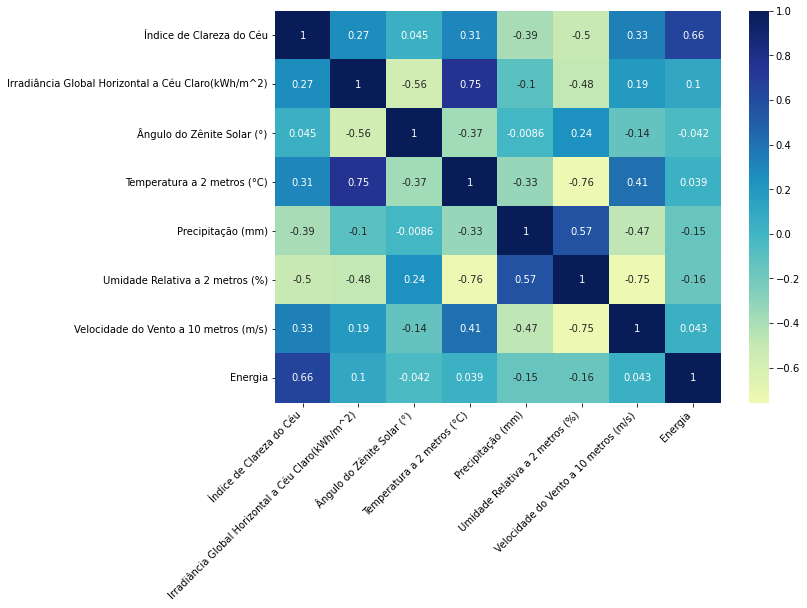

In [25]:
fig = plt.figure(figsize=(10,8))

correlacao2 = data_hourly_FV.corr()

sns.heatmap(correlacao2, center=0, cmap='YlGnBu',annot=True)
fig.autofmt_xdate(rotation=45)

In [26]:
data_hourly_FV.drop(['Precipitação (mm)','Velocidade do Vento a 10 metros (m/s)'],axis=1,inplace=True)

In [27]:
data_hourly_FV.rename(columns={'Irradiância Global Horizontal a Céu Claro(kWh/m^2)':'IGH1','Ângulo do Zênite Solar (°)':'Ângulo do Zênite Solar'},inplace=True)

In [28]:
data_hourly_FV

,Índice de Clareza do Céu,IGH1,Ângulo do Zênite Solar,Temperatura a 2 metros (°C),Umidade Relativa a 2 metros (%),Energia
DATA,,,,,,
2018-08-01,0.301304,278.936957,27.551304,28.852174,52.981739,15031.41
2018-08-02,0.297500,267.675417,26.341250,28.487500,50.562083,12754.93
2018-08-03,0.338750,278.485833,26.280417,27.872917,46.375000,16581.87
2018-08-04,0.314167,276.747083,26.217917,28.124583,47.484167,15573.27
2018-08-05,0.328750,274.777500,26.153750,29.085000,50.660000,16056.71
...,...,...,...,...,...,...
2021-02-20,0.307083,312.127917,26.277083,28.108333,66.469583,14190.33
2021-02-21,0.286667,315.552500,26.262500,29.076250,61.997500,13645.42
2021-02-22,0.336250,321.058750,26.249167,29.329583,58.138333,16692.07


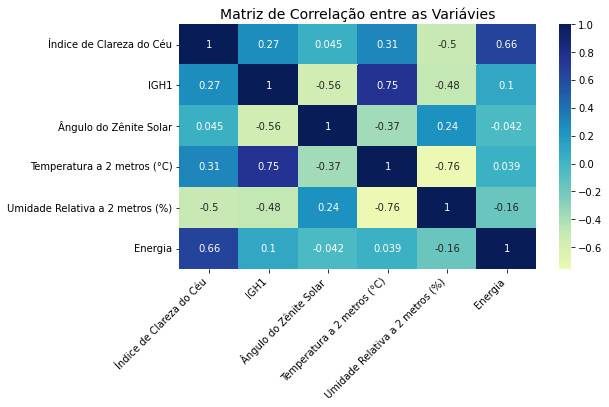

In [29]:
correlacao3 = data_hourly_FV.corr()

fig = plt.figure(figsize=(8,5))

sns.heatmap(correlacao3, center=0, cmap='YlGnBu',annot=True)
plt.title('Matriz de Correlação entre as Variávies', fontsize = 14)
fig.autofmt_xdate(rotation=45)

In [30]:
data_hourly_FV['IGH'] = data_hourly_FV['IGH1']
data_hourly_FV


,Índice de Clareza do Céu,IGH1,Ângulo do Zênite Solar,Temperatura a 2 metros (°C),Umidade Relativa a 2 metros (%),Energia,IGH
DATA,,,,,,,
2018-08-01,0.301304,278.936957,27.551304,28.852174,52.981739,15031.41,278.936957
2018-08-02,0.297500,267.675417,26.341250,28.487500,50.562083,12754.93,267.675417
2018-08-03,0.338750,278.485833,26.280417,27.872917,46.375000,16581.87,278.485833
2018-08-04,0.314167,276.747083,26.217917,28.124583,47.484167,15573.27,276.747083
2018-08-05,0.328750,274.777500,26.153750,29.085000,50.660000,16056.71,274.777500
...,...,...,...,...,...,...,...
2021-02-20,0.307083,312.127917,26.277083,28.108333,66.469583,14190.33,312.127917
2021-02-21,0.286667,315.552500,26.262500,29.076250,61.997500,13645.42,315.552500
2021-02-22,0.336250,321.058750,26.249167,29.329583,58.138333,16692.07,321.058750


In [31]:
data_hourly_FV.rename(columns={'GHI':'IGH1'},inplace=True)

In [32]:
data_hourly_FV.drop(['IGH1'],axis=1,inplace=True)
data_hourly_FV


,Índice de Clareza do Céu,Ângulo do Zênite Solar,Temperatura a 2 metros (°C),Umidade Relativa a 2 metros (%),Energia,IGH
DATA,,,,,,
2018-08-01,0.301304,27.551304,28.852174,52.981739,15031.41,278.936957
2018-08-02,0.297500,26.341250,28.487500,50.562083,12754.93,267.675417
2018-08-03,0.338750,26.280417,27.872917,46.375000,16581.87,278.485833
2018-08-04,0.314167,26.217917,28.124583,47.484167,15573.27,276.747083
2018-08-05,0.328750,26.153750,29.085000,50.660000,16056.71,274.777500
...,...,...,...,...,...,...
2021-02-20,0.307083,26.277083,28.108333,66.469583,14190.33,312.127917
2021-02-21,0.286667,26.262500,29.076250,61.997500,13645.42,315.552500
2021-02-22,0.336250,26.249167,29.329583,58.138333,16692.07,321.058750


In [33]:
aux = data_hourly_FV.iloc[:,0:-2].resample(freq).mean()
aux2 = data_hourly_FV.iloc[:,-2:].resample(freq).sum()

dados_diarios = pd.concat([aux,aux2],axis=1)

In [34]:
cols = ['Índice de Clareza do Céu','Ângulo do Zênite Solar','Temperatura a 2 metros (°C)','Umidade Relativa a 2 metros (%)','IGH','Energia'] 
dados_diarios = dados_diarios[cols]

In [35]:
dados_diarios.rename(columns={'Índice de Clareza do Céu':'kt',
                      'Temperatura a 2 metros (°C)': 'Temperatura',
                      'Umidade Relativa a 2 metros (%)':'Umidade'},inplace=True)
dados_diarios

,kt,Ângulo do Zênite Solar,Temperatura,Umidade,IGH,Energia
DATA,,,,,,
2018-08-01,0.301304,27.551304,28.852174,52.981739,278.936957,15031.41
2018-08-02,0.297500,26.341250,28.487500,50.562083,267.675417,12754.93
2018-08-03,0.338750,26.280417,27.872917,46.375000,278.485833,16581.87
2018-08-04,0.314167,26.217917,28.124583,47.484167,276.747083,15573.27
2018-08-05,0.328750,26.153750,29.085000,50.660000,274.777500,16056.71
...,...,...,...,...,...,...
2021-02-20,0.307083,26.277083,28.108333,66.469583,312.127917,14190.33
2021-02-21,0.286667,26.262500,29.076250,61.997500,315.552500,13645.42
2021-02-22,0.336250,26.249167,29.329583,58.138333,321.058750,16692.07


In [36]:
dados_diarios.dropna(axis=0,inplace=True)

In [37]:
# if freq == 'H':
#   dados_diarios = dados_diarios.reset_index()
#   dados_diarios_temp = dados_diarios['Energia'].where(dados_diarios['Energia']<10).dropna(axis=0)
#   dados_diarios_ix = dados_diarios_temp.index
#   dados_diarios = dados_diarios.drop(dados_diarios_ix,axis=0)
#   dados_diarios.set_index(['DATA'],inplace=True)

##Tratamento dos dados

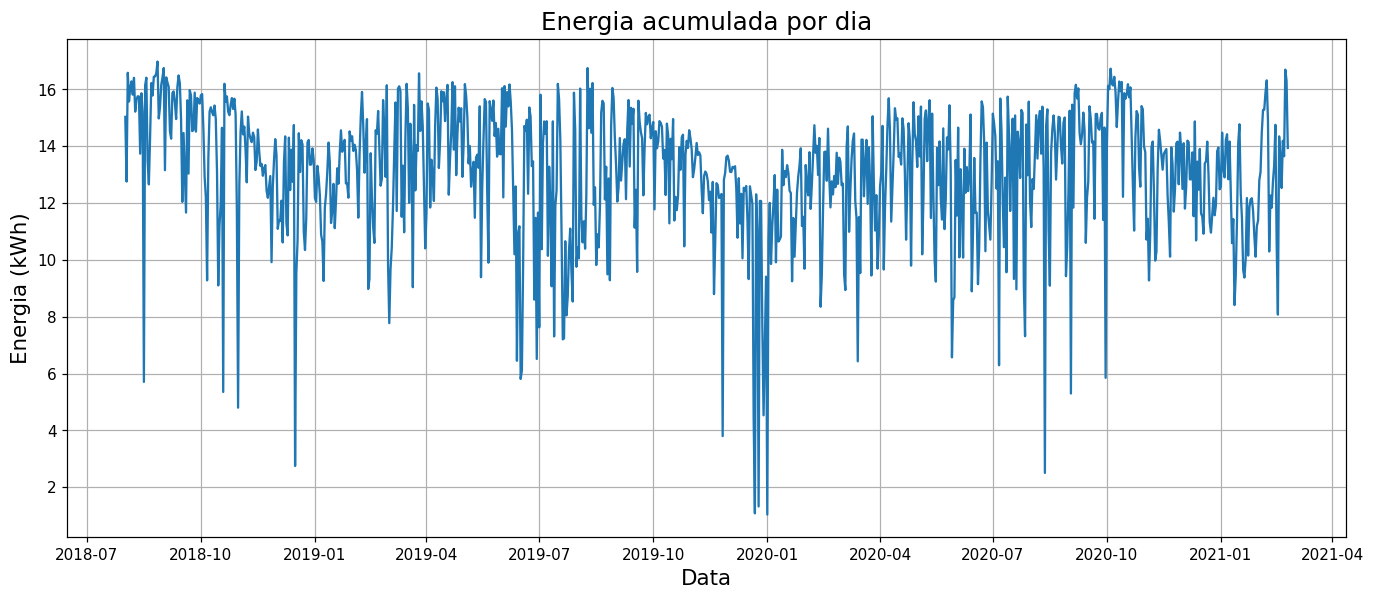

In [38]:
plt.figure(figsize=(15,6),dpi=110)
plt.plot(dados_diarios['Energia']/1e3)
plt.title('Energia acumulada por dia',fontsize=16)
plt.ylabel('Energia (kWh)',fontsize=14)
plt.xlabel('Data',fontsize=14)
plt.grid()

In [39]:
# Check missing values
# dados_diarios.isnull().sum()

In [40]:
#Outlier detection
up_b = dados_diarios.mean() + 3*dados_diarios.std()
low_b = dados_diarios.mean() - 3*dados_diarios.std()

print('up: ',up_b)
print('low: ',low_b)

up:  kt                            0.428735
Ângulo do Zênite Solar       31.130233
Temperatura                  34.238438
Umidade                      93.756746
IGH                         369.350472
Energia                   20058.721814
dtype: float64
low:  kt                           0.180668
Ângulo do Zênite Solar      23.812222
Temperatura                 23.581936
Umidade                     20.715316
IGH                        226.551884
Energia                   6110.906983
dtype: float64


In [41]:
dados_diarios[dados_diarios > up_b] = np.nan
dados_diarios[dados_diarios < low_b] = np.nan
dados_diarios.interpolate(inplace=True)

In [42]:
# dados_diarios.to_csv() 


(737791.0, 737792.0)

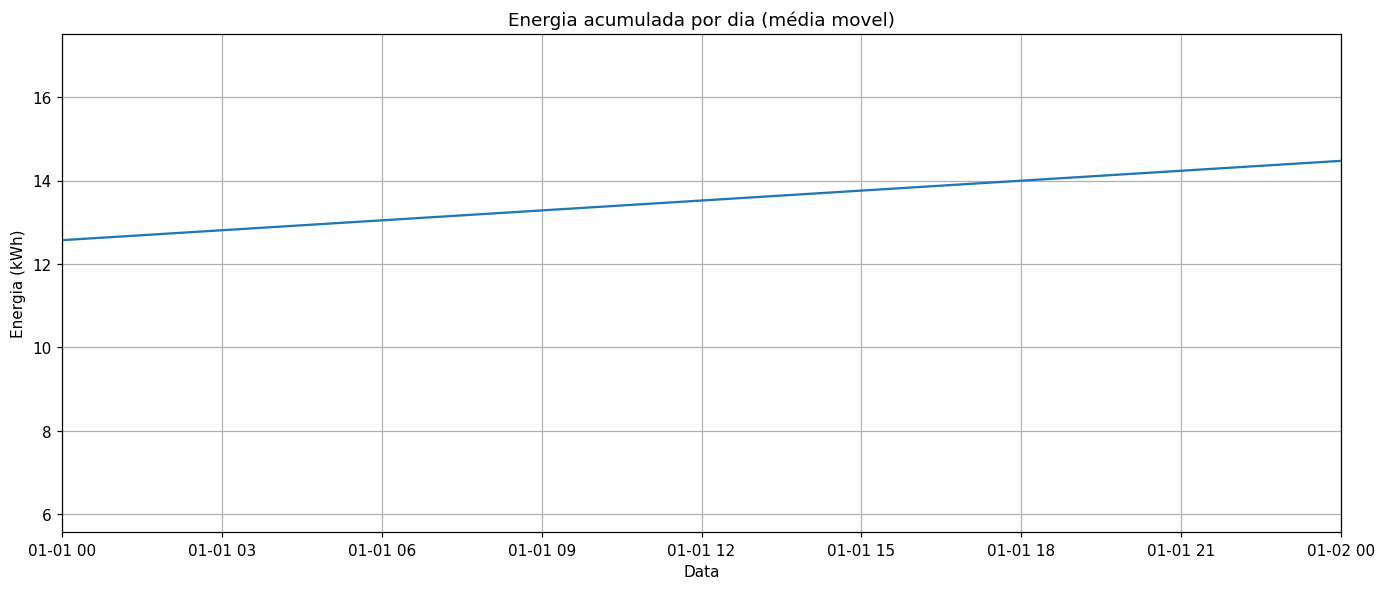

In [43]:
plt.figure(figsize=(15,6),dpi=110)
plt.plot(dados_diarios['Energia']/1e3)
plt.title('Energia acumulada por dia (média movel)')
plt.ylabel('Energia (kWh)')
plt.xlabel('Data')
plt.grid()
plt.xlim([datetime(2021, 1, 1), datetime(2021, 1, 2)])

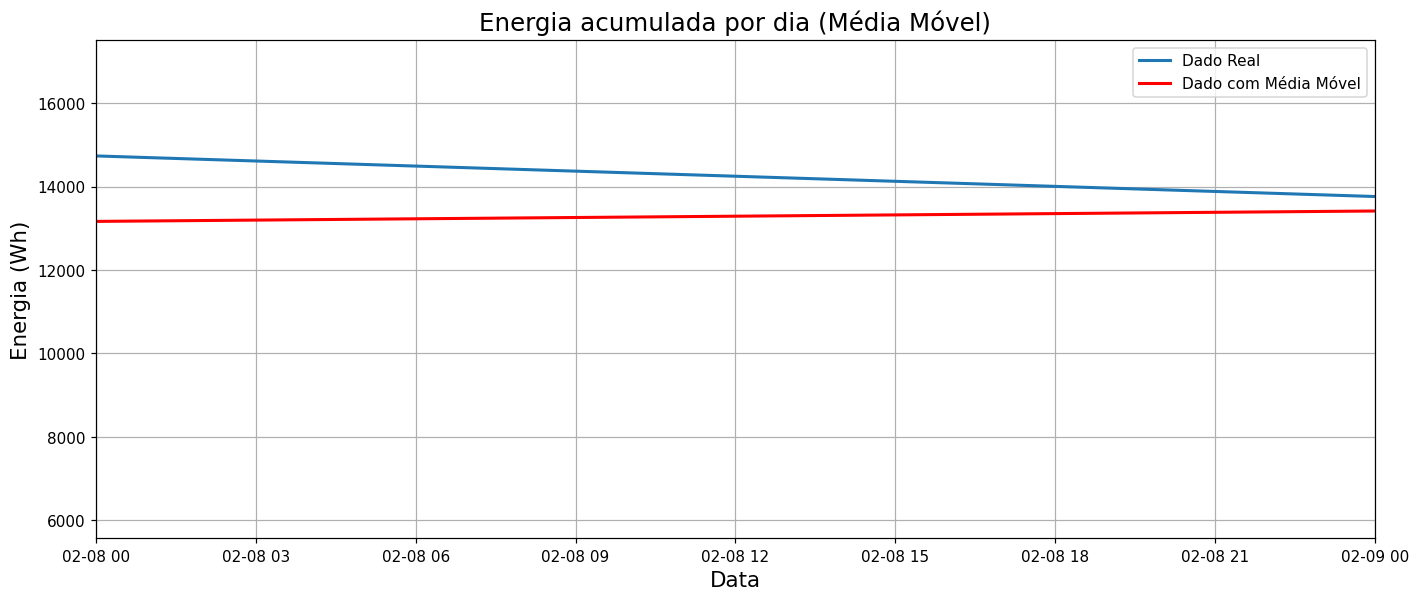

In [44]:
if freq == 'W':
  janela = 5
elif freq == 'D':
  janela = 6
elif freq == 'H':
  janela = 2

if freq == 'W' or freq == 'D' or freq=='H':
  dados_diarios_mm = dados_diarios.rolling(janela).mean().dropna()

  plt.figure(figsize=(15,6),dpi=110)
  plt.plot(dados_diarios['Energia'], lw=2)
  plt.plot(dados_diarios_mm['Energia'],'r', lw=2)
  plt.title('Energia acumulada por dia (Média Móvel)', fontsize=16)
  plt.ylabel('Energia (Wh)',fontsize=14)
  plt.xlabel('Data',fontsize=14)
  plt.legend(['Dado Real','Dado com Média Móvel'])
  plt.grid()
  plt.xlim([datetime(2020, 2, 8), datetime(2020, 2, 9)])

#pd.DataFrame(maxima_diaria_mm)

In [45]:
# #Média Móvel
# maxima_semanal_mm = maxima_semanal['Energia'].rolling(5).mean().dropna()

# plt.figure(figsize=(15,6),dpi=110)
# plt.plot(maxima_semanal)
# plt.plot(maxima_semanal_mm,'r')
# plt.title('Energia acumulada por semana (média movel)')
# plt.ylabel('Energia (Wh)')
# plt.xlabel('Data')
# #pd.DataFrame(maxima_semanal_mm)

##Formação do Banco de Dados

In [46]:
def data_proc(data,n_data_before,n_data_after):

  for i in range(1,n_data_before+1):
    data['kt(k-'+str(i)+')'] = data['kt'].shift(i)
    data['Temperatura(k-'+str(i)+')'] = data['Temperatura'].shift(i)
    data['Umidade(k-'+str(i)+')'] = data['Umidade'].shift(i)
    data['IGH (k-'+str(i)+')'] = data['IGH'].shift(i)
    data['Ângulo do Zênite Solar(k-'+str(i)+')'] = data['Ângulo do Zênite Solar'].shift(i)
    data['Energia(k-'+str(i)+')'] = data['Energia'].shift(i)

   
  for j in range(1,n_data_after+1):
    data['Energia(k+'+str(j)+')'] = data['Energia'].shift(-j)
        
  return data

In [47]:
def data_proc1(data,n_data_tested,n_data_predict):

  for i in range(1,n_data_before+1):
    data['Energia(k-'+str(i)+')'] = data['Energia'].shift(i)

   
  for j in range(1,n_data_after+1):
    data['Energia(k+'+str(j)+')'] = data['Energia'].shift(-j)

     
  return data


##Separação dos conjuntos de Treino e Teste

In [48]:
#implementação da RNA
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM
from keras.layers import Dense

In [49]:
def Normalize(data):
    data_max = data.max(axis=0)
    data_min = data.min(axis=0)
    return (data-data_min)/(data_max-data_min)
    # w = np.sqrt((data**2).sum(axis=0))
    # x_norm2 = data/w
    # return x_norm2

def Denormalize(data_normalized, data):
    data_max = data.max(axis=0)
    data_min = data.min(axis=0)
    return data_normalized*(data_max-data_min) + data_min
    # w = np.sqrt((data**2).sum(axis=0))
    # data_denormalized = data_normalized*w
    # return data_denormalized

In [50]:
def sMAPE_fn(actual,forecast):
  sMAPE = 100/len(actual) * np.sum(np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))
  return sMAPE

In [51]:
n_data_before = 7
n_data_after = 1

if freq == 'H':
  data = dados_diarios
else:
  data = dados_diarios_mm

#data = maxima_hora 

bd = data_proc(data,n_data_before,n_data_after)
# bd = data_proc1(data,n_data_before,n_data_after)

inputs = bd.iloc[:,0:-n_data_after]
outputs = bd.iloc[:,-n_data_after:]

#normalização
data_norm = Normalize(bd)

dados_diarios_norm = data_proc(data_norm,n_data_before,n_data_after)

# dados_diarios_norm = data_proc1(data_norm,n_data_before,n_data_after)

dados_diarios_norm.dropna(axis=0,inplace=True)

data_norm = dados_diarios_norm

inputs_norm = data_norm.iloc[:,0:-n_data_after]
outputs_norm = data_norm.iloc[:,-n_data_after:]

#data_norm = tf.keras.utils.normalize(bd,order=2)

input_train = data_norm.iloc[0:int(0.7*len(inputs_norm)),0:-n_data_after]
input_test = data_norm.iloc[int(0.7*len(inputs_norm)):-1,0:-n_data_after] 

output_train = data_norm.iloc[0:int(0.7*len(outputs_norm)),-n_data_after:]
output_test = data_norm.iloc[int(0.7*len(outputs_norm)):-1,-n_data_after:] 


In [52]:
dados_diarios_norm.head(10)

,kt,Ângulo do Zênite Solar,Temperatura,Umidade,IGH,Energia,kt(k-1),Temperatura(k-1),Umidade(k-1),IGH (k-1),...,IGH (k-6),Ângulo do Zênite Solar(k-6),Energia(k-6),kt(k-7),Temperatura(k-7),Umidade(k-7),IGH (k-7),Ângulo do Zênite Solar(k-7),Energia(k-7),Energia(k+1)
DATA,,,,,,,,,,,,,,,,,,,,,
2018-08-13,0.792611,0.664494,0.483251,0.200585,0.413742,0.871411,0.850739,0.468498,0.190556,0.421276,...,0.373404,0.026224,0.883546,0.690705,0.490646,0.157844,0.376610,0.085582,0.866668,0.859624
2018-08-14,0.785714,0.794703,0.497421,0.201006,0.406362,0.859624,0.792611,0.483251,0.200585,0.413742,...,0.399274,0.011385,0.962461,0.729557,0.487320,0.143278,0.373404,0.026224,0.883546,0.859075
2018-08-15,0.792118,0.778794,0.498165,0.190941,0.410544,0.859075,0.785714,0.497421,0.201006,0.406362,...,0.400432,0.142308,0.932930,0.781773,0.483370,0.137458,0.399274,0.011385,0.962461,0.859763
2018-08-16,0.754680,0.762787,0.496860,0.193311,0.400677,0.859763,0.792118,0.498165,0.190941,0.410544,...,0.408369,0.273102,0.934256,0.771921,0.488442,0.163753,0.400432,0.142308,0.932930,0.868101
2018-08-17,0.734975,0.746716,0.503173,0.201143,0.403594,0.868101,0.754680,0.496860,0.193311,0.400677,...,0.425167,0.403733,0.927783,0.813793,0.498575,0.178666,0.408369,0.273102,0.934256,0.882409
2018-08-18,0.739901,0.730580,0.481449,0.171573,0.424717,0.882409,0.734975,0.503173,0.201143,0.403594,...,0.421276,0.534219,0.916289,0.850739,0.473991,0.166823,0.425167,0.403733,0.927783,0.876885
2018-08-19,0.788670,0.714395,0.436360,0.161105,0.441201,0.876885,0.739901,0.481449,0.171573,0.424717,...,0.413742,0.664494,0.871411,0.850739,0.468498,0.190556,0.421276,0.534219,0.916289,0.807608
2018-08-20,0.766995,0.698096,0.401006,0.165107,0.446782,0.807608,0.788670,0.436360,0.161105,0.441201,...,0.406362,0.794703,0.859624,0.792611,0.483251,0.200585,0.413742,0.664494,0.871411,0.788688
2018-08-21,0.750739,0.681749,0.393020,0.166569,0.449897,0.788688,0.766995,0.401006,0.165107,0.446782,...,0.410544,0.778794,0.859075,0.785714,0.497421,0.201006,0.406362,0.794703,0.859624,0.800681


In [53]:
entrada_train = tf.convert_to_tensor(input_train)
saida_train = tf.convert_to_tensor(output_train)
entrada_test = tf.convert_to_tensor(input_test)
saida_test = tf.convert_to_tensor(output_test)

Text(0.5, 1.0, 'Dados de Treinamento e Validação')

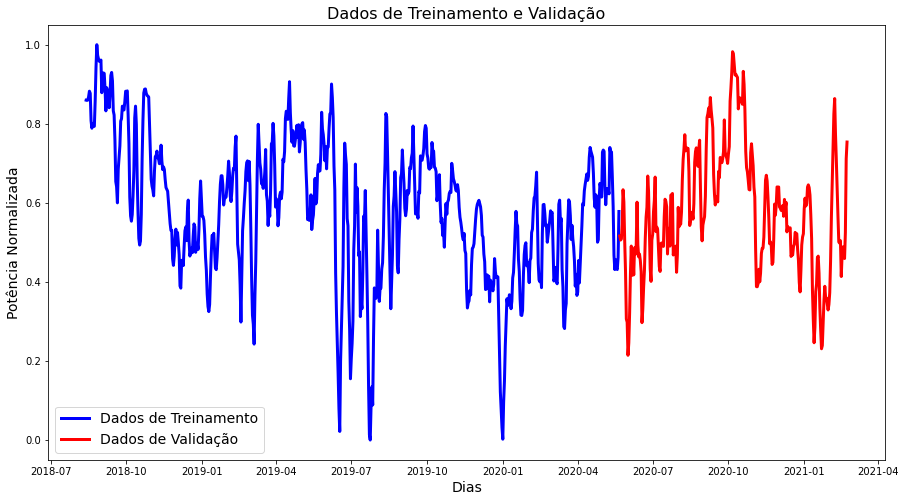

In [54]:
plt.figure(figsize=(15,8))
plt.plot(output_train.iloc[:,0],'b',lw=3)
plt.plot(output_test.iloc[:,0],'r',lw=3)
plt.legend(['Dados de Treinamento','Dados de Validação'],fontsize=14)
plt.xlabel('Dias',fontsize=14)
plt.ylabel('Potência Normalizada',fontsize=14)
plt.title('Dados de Treinamento e Validação',fontsize=16)
#plt.xlim([datetime(2020, 5, 5), datetime(2020, 5, 25)])

##Montagem da Rede Neural Artificial

In [55]:
from keras.layers import SimpleRNN

In [56]:
 
def create_model(inputs,outputs,n_neurons,activation_fn,type_nn):
  if type_nn == 'ff':
    model = keras.Sequential([
    keras.Input(shape=(len(inputs.columns),)),  # input layer (1)
    keras.layers.Dense(n_neurons, activation=activation_fn,
                      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                      bias_regularizer=regularizers.l2(1e-4),
                      activity_regularizer=regularizers.l2(1e-5)),  # hidden layer (1)
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(n_neurons/2, activation=activation_fn,
                      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                      bias_regularizer=regularizers.l2(1e-4),
                      activity_regularizer=regularizers.l2(1e-5)),  # hidden layer (2)
    
    # keras.layers.Dense(n_neurons, activation=activation_fn,
    #                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    #                    bias_regularizer=regularizers.l2(1e-4),
    #                    activity_regularizer=regularizers.l2(1e-5)),  # hidden layer (3)
                            
          #keras.layers.Dropout(0.2),
    keras.layers.Dense(len(outputs.columns), activation=activation_fn) # output layer 
    ])
  if type_nn == 'lstm':
    model = keras.Sequential()
    model.add(SimpleRNN(128,input_shape = (inputs.shape[1],inputs.shape[2]),return_sequences=True))
    model.add(Dense(1))


  return model



In [57]:
n_neurons = 100
activation_fn = 'tanh'
type_nn = 'ff'

if type_nn == 'lstm':
  inputs = np.reshape(entrada_train, (entrada_train.shape[0],entrada_train.shape[1],1))
  outputs = np.reshape(saida_train, (saida_train.shape[0],saida_train.shape[1],1))
  model = create_model(inputs,outputs,n_neurons,activation_fn,type_nn)

if type_nn == 'ff':
  model = create_model(input_train,output_train,n_neurons,activation_fn,type_nn)

model.compile(optimizer ='adam',
              loss='mse',
              metrics=['mae','accuracy'])

model.summary()

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',mode='min',patience = 10)

historico = model.fit(entrada_train, saida_train, shuffle=True, epochs=500,
                      validation_data=(input_test, output_test),callbacks=early_stop)

                        

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4900      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
21/21 [==============================] - 1s 12ms/step - loss: 0.1589 - mae: 0.3103 - accuracy: 0.0031 - val_loss: 0.0576 - val_mae: 0.1534 - val_accuracy: 0.0000e+00
Epoch 2/500
21/21 [==============================] - 0s 3ms/step - loss: 0.0551 - mae: 0.1392 - accuracy: 0.0000e+00 - val_loss: 0.0403 - 

##Avaliação dos Resultados

In [58]:
test_loss, test_mae, val_acc = model.evaluate(entrada_test, saida_test, verbose=1) 
#print('Test accuracy:', test_acc) 

9/9 [==============================] - 0s 2ms/step - loss: 0.0053 - mae: 0.0437 - accuracy: 0.0000e+00


In [59]:
from sklearn import metrics

y_hat_train = model.predict(input_train)
print(metrics.r2_score(output_train, y_hat_train))

y_hat_test = model.predict(input_test)
print(metrics.r2_score(output_test, y_hat_test))

0.9136920907662055
0.8751498465505184


Text(0, 0.5, 'Loss')

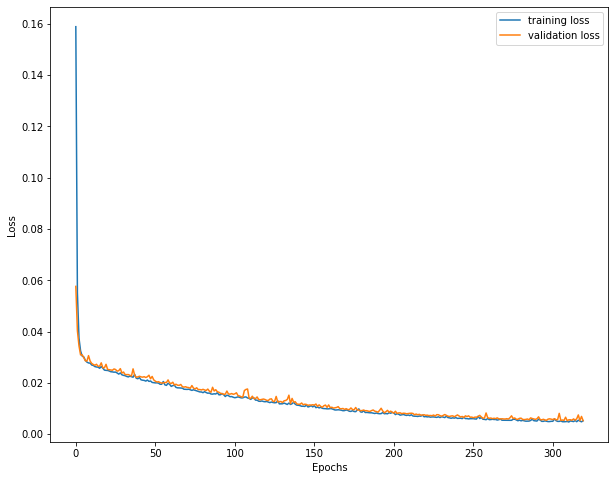

In [60]:
plt.figure(figsize=(10,8))
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

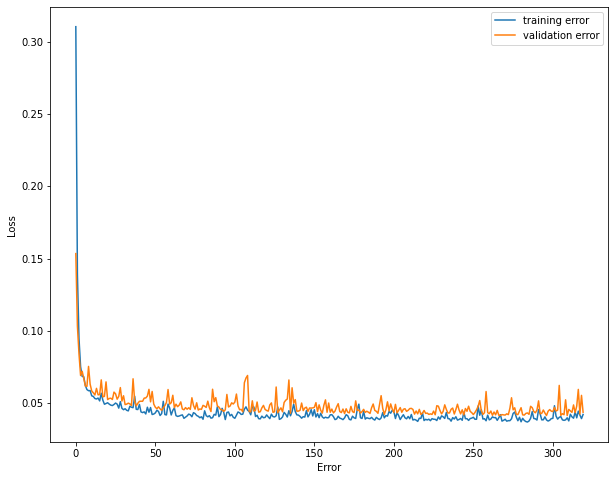

In [61]:
plt.figure(figsize=(10,8))
plt.plot(historico.history['mae'])
plt.plot(historico.history['val_mae'])
plt.legend(['training error','validation error'])
plt.xlabel('Error')
plt.ylabel('Loss')

In [62]:
predictions = model.predict(entrada_test)

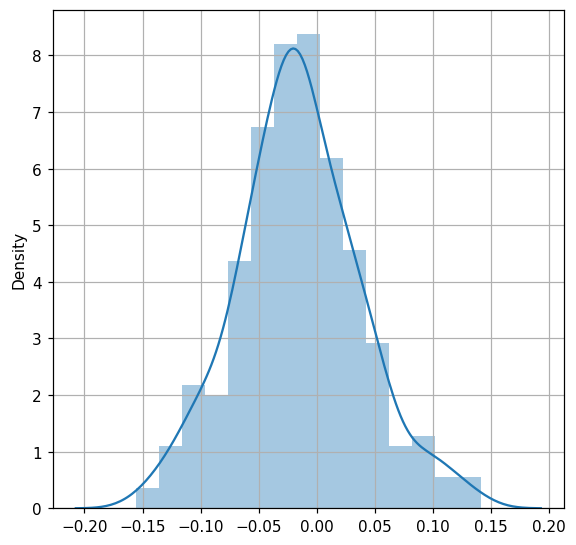

In [63]:
import seaborn as sns

plt.figure(figsize=(6,6),dpi=110)
plt.grid(True)
#plt.plot(predictions[:,0]-saida_test[:,0])
#plt.xlim([0,91])
sns.distplot(predictions[:,0]-saida_test[:,0])

####DADOS NORMALIZADOS

In [64]:
MAPE = keras.metrics.mean_absolute_percentage_error(output_test,predictions)
MAE = keras.metrics.mean_absolute_error(output_test,predictions)
MSE = keras.metrics.mean_squared_error(output_test,predictions)
RMSE = np.sqrt(keras.metrics.mean_squared_error(output_test,predictions))
sMAPE = sMAPE_fn(output_test,predictions)

print('RMSE: ',np.mean(RMSE))
print('MSE: ',np.mean(MSE))
print('MAE: ',np.mean(MAE))
print(f'MAPE: {np.mean(MAPE)} %')
print(f'sMAPE: {np.mean(sMAPE)} %')

RMSE:  0.043712933
MSE:  0.0030361975
MAE:  0.043712933
MAPE: 7.81959867477417 %
sMAPE: 3.953903584730144 %


####Estações do ano

In [65]:
pred_data_hourly = pd.DataFrame(predictions)
pred_data_hourly.columns=['predicoes']
aux = output_test.reset_index()
data_hourly_plot = pd.concat([pred_data_hourly,aux],axis=1)
data_hourly_plot.set_index(['DATA'],inplace=True)
data_hourly_plot.rename(columns={'Energia(k+1)':'original'},inplace=True)

In [66]:
MAPE = keras.metrics.mean_absolute_percentage_error(data_hourly_plot['original']['2020-12-21':'2021-03-21'],data_hourly_plot['predicoes']['2020-12-21':'2021-03-21'])
MAE = keras.metrics.mean_absolute_error(data_hourly_plot['original']['2020-12-21':'2021-03-21'],data_hourly_plot['predicoes']['2020-12-21':'2021-03-21'])

print('MAE Verão: ', np.mean(MAE))
print(f'MAPE Verão: {np.mean(MAPE)} %')

MAE Verão:  0.040791273
MAPE Verão: 8.586411476135254 %


In [67]:
MAPE = keras.metrics.mean_absolute_percentage_error(data_hourly_plot['original']['2020-03-21':'2020-06-21'],data_hourly_plot['predicoes']['2020-03-21':'2020-06-21'])
MAE = keras.metrics.mean_absolute_error(data_hourly_plot['original']['2020-03-21':'2020-06-21'],data_hourly_plot['predicoes']['2020-03-21':'2020-06-21'])

print('MAE Outono: ', np.mean(MAE))
print(f'MAPE Outono: {np.mean(MAPE)} %')

MAE Outono:  0.048972536
MAPE Outono: 11.442543983459473 %


In [68]:
MAPE = keras.metrics.mean_absolute_percentage_error(data_hourly_plot['original']['2020-06-21':'2020-09-21'],data_hourly_plot['predicoes']['2020-06-21':'2020-09-21'])
MAE = keras.metrics.mean_absolute_error(data_hourly_plot['original']['2020-06-21':'2020-09-21'],data_hourly_plot['predicoes']['2020-06-21':'2020-09-21'])

print('MAE Inverno: ', np.mean(MAE))
print(f'MAPE Inverno: {np.mean(MAPE)} %')

MAE Inverno:  0.0441494
MAPE Inverno: 7.518914222717285 %


In [69]:
MAPE = keras.metrics.mean_absolute_percentage_error(data_hourly_plot['original']['2020-09-21':'2020-12-21'],data_hourly_plot['predicoes']['2020-09-21':'2020-12-21'])
MAE = keras.metrics.mean_absolute_error(data_hourly_plot['original']['2020-09-21':'2020-12-21'],data_hourly_plot['predicoes']['2020-09-21':'2020-12-21'])

print('MAE Primavera: ', np.mean(MAE))
print(f'MAPE Primavera: {np.mean(MAPE)} %')

MAE Primavera:  0.04343926
MAPE Primavera: 6.359756946563721 %


####DADOS DESNORMALIZADOS

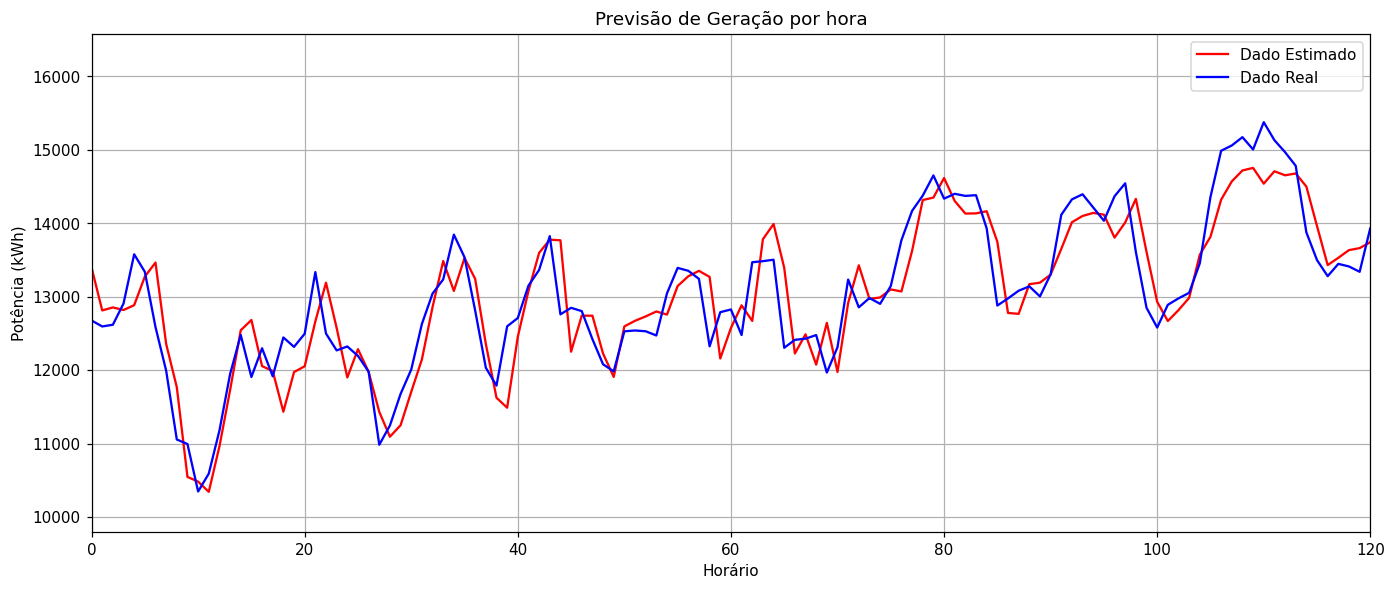

In [70]:
pred = Denormalize(predictions,outputs['Energia(k+1)'])
sd = np.array(Denormalize(output_test,outputs))

plt.figure(figsize=(15,6),dpi=110)
plt.plot(pred[:,0],'r')
plt.plot(sd[:,0],'b')
plt.xlim([0,120])
plt.legend(['Dado Estimado','Dado Real'])
plt.grid()
plt.title('Previsão de Geração por hora')
plt.xlabel('Horário')
plt.ylabel('Potência (kWh)')
plt.show() 

In [71]:
MAPE = keras.metrics.mean_absolute_percentage_error(sd,pred)
MAE = keras.metrics.mean_absolute_error(sd,pred)
MSE = keras.metrics.mean_squared_error(sd,pred)
RMSE = np.sqrt(keras.metrics.mean_squared_error(sd,pred))
sMAPE = sMAPE_fn(sd,pred)

print('RMSE: ',np.mean(RMSE))
print('MSE: ', np.mean(MSE))
print('MAE: ', np.mean(MAE))
#print(f'MAPE: {np.mean(MAPE)} %')
print(f'sMAPE: {np.mean(sMAPE)} %')
print(f'MAAPE: {np.mean(100*np.arctan(MAPE/100))} %')

RMSE:  337.12155
MSE:  180585.64
MAE:  337.12155
sMAPE: 1.2760522743237823 %
MAAPE: 2.5354080200195312 %


In [72]:
out_t = Denormalize(output_test,outputs) 
in_t = Denormalize(input_test,inputs) 
energia_diaria = out_t.iloc[:,0].sum()/1e3
pred_energia_diaria = pred[:,0].sum()/1e3
print('Energia diária do banco de dados original: {0} kW'.format(energia_diaria))
print('Previsão de energia diária: {0} kW'.format(pred_energia_diaria))

Energia diária do banco de dados original: 3641.498675 kW
Previsão de energia diária: 3608.0145 kW


####Estações do ano

In [73]:
pred_data_hourly = pd.DataFrame(pred[:,0])
sd_data_hourly = pd.DataFrame(sd)
pred_data_hourly.columns=['predicoes']
sd_data_hourly.columns=['original']
aux = output_test.reset_index()
x = pd.concat([pred_data_hourly,aux],axis=1)
data_hourly_plot = pd.concat([x,sd_data_hourly],axis=1)
data_hourly_plot.set_index(['DATA'],inplace=True)
# data_hourly_plot.set_index(['TEMPO'],inplace=True)
data_hourly_plot.drop(['Energia(k+1)'], axis=1,inplace=True)
data_hourly_plot

,predicoes,original
DATA,,
2020-05-22,13398.042969,12677.383333
2020-05-23,12814.001953,12595.885000
2020-05-24,12855.042969,12619.223333
2020-05-25,12819.984375,12908.156667
2020-05-26,12885.675781,13578.506667
...,...,...
2021-02-18,12817.425781,12330.378333
2021-02-19,12428.958008,12236.911667
2021-02-20,12342.380859,12746.933333


In [74]:
verao_pred = data_hourly_plot['predicoes']['2020-12-21':'2021-03-21']/1e3
verao_original = data_hourly_plot['original']['2020-12-21':'2021-03-21']/1e3

MAPE = keras.metrics.mean_absolute_percentage_error(verao_original,verao_pred)
MAE = keras.metrics.mean_absolute_error(verao_original,verao_pred)
RMSE = np.sqrt(keras.metrics.mean_squared_error(verao_original,verao_pred))
sMAPE = sMAPE_fn(verao_original,verao_pred)


print('MAE Verão: ', np.mean(MAE))
print('RMSE Verão: ', np.mean(RMSE))
print(f'MAPE Verão: {np.mean(MAPE)} %')
print(f'sMAPE Verão: {np.mean(sMAPE)} %')

MAE Verão:  0.31458935
RMSE Verão:  0.3901344
MAPE Verão: 2.4867801666259766 %
sMAPE Verão: 1.2526633042608637 %


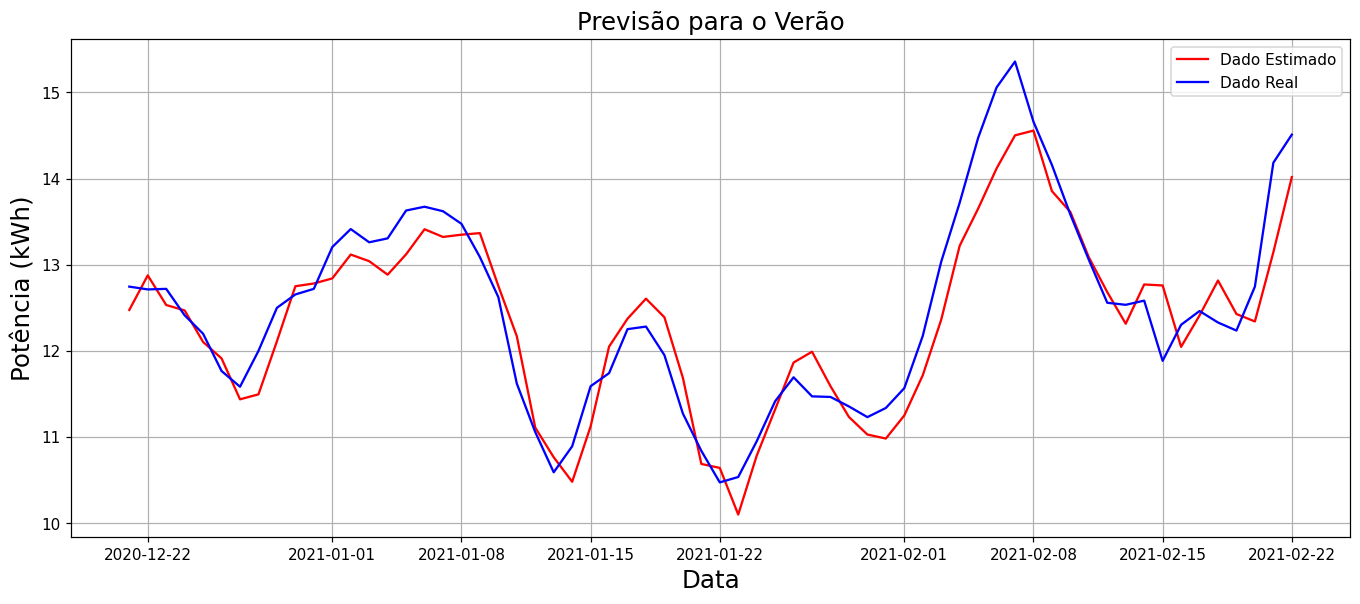

In [75]:

if freq == 'H':
  energia_verao_pred = verao_pred['2021-02-08']
  energia_verao = verao_original['2021-02-08']
  hr = np.array(energia_verao.index.time)
  hr = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(hr,energia_verao['2021-02-08'],'r')
  plt.plot(hr,energia_verao_pred['2021-02-08'],'b')
  plt.xticks(np.arange(0, len(hr)+1, 1.5))
  plt.text(10,1.7,'Produção Total de Energia: %.2f kW'%(round(energia_verao.sum(),2)),
          fontsize = 14, bbox = dict(facecolor = 'blue', alpha = 0.8))
  arr = round(energia_verao_pred.sum(),2)
  plt.text(10,1.5,'Previsão Total de Energia: %.2f kW'%(arr),
          fontsize = 14, bbox = dict(facecolor = 'red', alpha = 0.8))
  plt.xlabel('Horário')
  plt.ylabel('Potência (kW)')
  plt.legend(['Dado Estimado','Dado Real'])
  plt.title('Potência para o Verão',fontsize=16)
  plt.grid()
  plt.show()

elif freq == 'D':
  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(verao_pred,'r')
  plt.plot(verao_original,'b')
  plt.xlabel('Data',fontsize=16)
  plt.ylabel('Potência (kWh)',fontsize=16)
  plt.legend(['Dado Estimado','Dado Real'])
  plt.title('Previsão para o Verão',fontsize=16)
  plt.grid()
  plt.show()



In [76]:
outono_pred = data_hourly_plot['predicoes']['2020-03-21':'2020-06-21']/1e3
outono_original = data_hourly_plot['original']['2020-03-21':'2020-06-21']/1e3

MAPE = keras.metrics.mean_absolute_percentage_error(outono_original,outono_pred)
MAE = keras.metrics.mean_absolute_error(outono_original,outono_pred)
RMSE = np.sqrt(keras.metrics.mean_squared_error(outono_original,outono_pred))
sMAPE = sMAPE_fn(outono_original,outono_pred)

print('RMSE Outono: ', np.mean(RMSE))
print('MAE Outono: ', np.mean(MAE))
print(f'MAPE Outono: {np.mean(MAPE)} %')
print(f'sMAPE Outono: {np.mean(sMAPE)} %')


RMSE Outono:  0.46194598
MAE Outono:  0.37768468
MAPE Outono: 3.110443592071533 %
sMAPE Outono: 1.5536040120350154 %


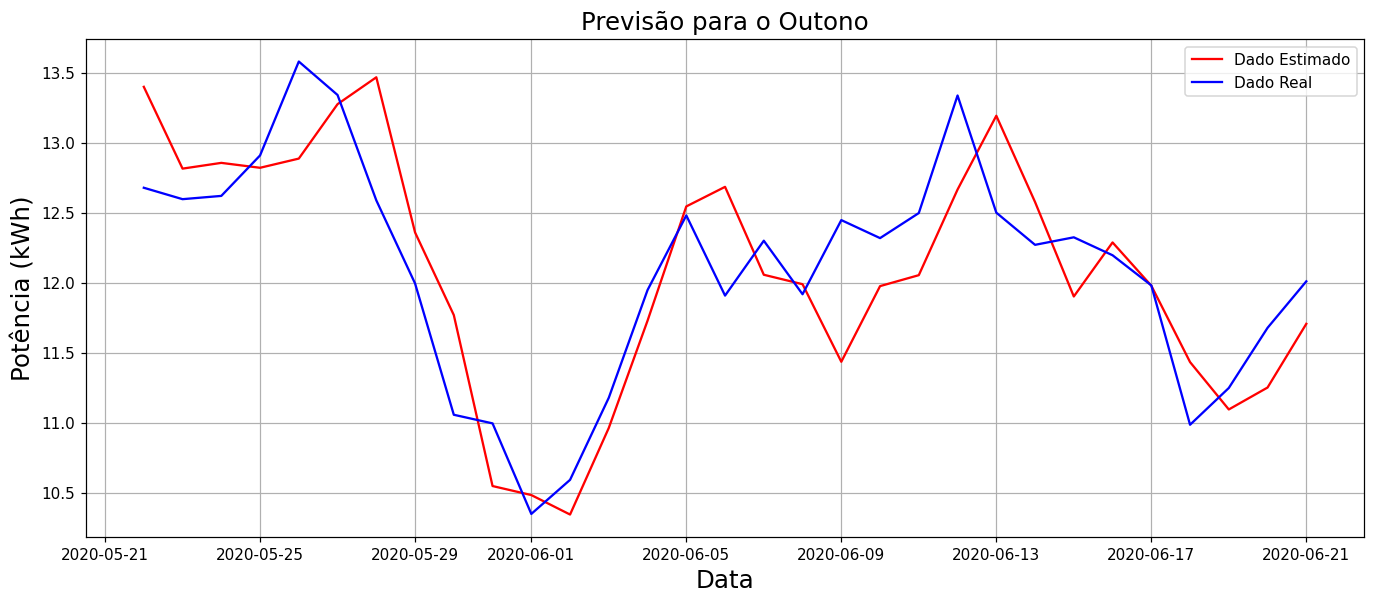

In [77]:
if freq == 'H':
  energia_outono_pred = outono_pred['2020-05-25']
  energia_outono = outono_original['2020-05-25']
  hr = np.array(energia_outono.index.time)
  hr = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(hr,energia_outono['2020-05-25'],'r')
  plt.plot(hr,energia_outono_pred['2020-05-25'],'b')
  plt.xticks(np.arange(0, len(hr)+1, 1.5))
  plt.text(16,1.7,'Produção Total de Energia: %.2f kW'%round(energia_outono.sum(),2),
          fontsize = 14, bbox = dict(facecolor = 'blue', alpha = 0.8))
  arr =energia_outono_pred.sum()
  plt.text(16,1.5,'Previsão Total de Energia: %.2f kW'%round(arr,2),
          fontsize = 14, bbox = dict(facecolor = 'red', alpha = 0.8))
  plt.xlabel('Horário')
  plt.ylabel('Potência (kW)')
  plt.legend(['Dado Estimado','Dado Real'])
  plt.title('Potência para o Outono',fontsize=16)
  plt.grid()
  plt.show()

elif freq == 'D':
  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(outono_pred,'r')
  plt.plot(outono_original,'b')
  plt.xlabel('Data',fontsize=16)
  plt.ylabel('Potência (kWh)',fontsize=16)
  plt.legend(['Dado Estimado','Dado Real'])
  plt.title('Previsão para o Outono',fontsize=16)
  plt.grid()
  plt.show()

In [78]:
inverno_pred = data_hourly_plot['predicoes']['2020-06-21':'2020-09-21']/1e3
inverno_original = data_hourly_plot['original']['2020-06-21':'2020-09-21']/1e3

MAPE = keras.metrics.mean_absolute_percentage_error(inverno_original,inverno_pred)
MAE = keras.metrics.mean_absolute_error(inverno_original,inverno_pred)
RMSE = np.sqrt(keras.metrics.mean_squared_error(inverno_original,inverno_pred))
sMAPE = sMAPE_fn(inverno_original,inverno_pred)

print('RMSE Inverno ', np.mean(RMSE))
print('MAE Inverno: ', np.mean(MAE))
print(f'MAPE Inverno: {np.mean(MAPE)} %')
print(f'sMAPE Inverno: {np.mean(sMAPE)} %')

RMSE Inverno  0.42814136
MAE Inverno:  0.3404876
MAPE Inverno: 2.5534138679504395 %
sMAPE Inverno: 1.2769045765332312 %


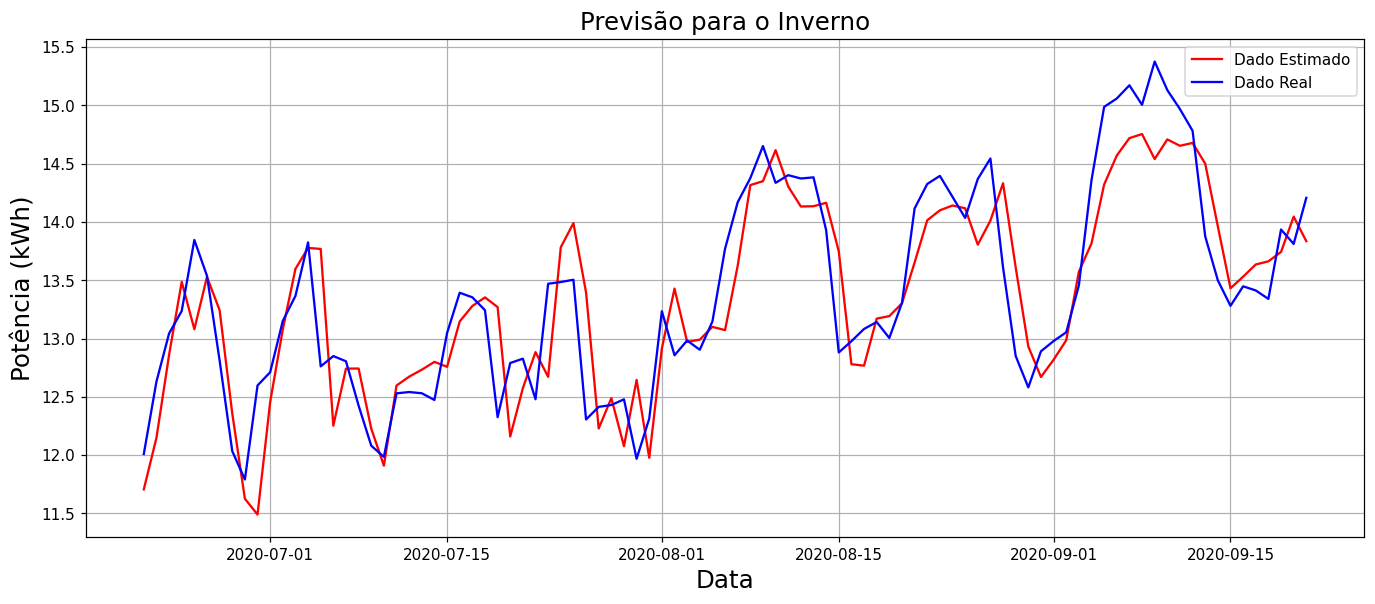

In [79]:
if freq == 'H':
  energia_inverno_pred = inverno_pred['2020-06-25']
  energia_inverno = inverno_original['2020-06-25']
  hr = np.array(energia_inverno.index.time)
  hr = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(hr,energia_inverno['2020-06-25'],'r')
  plt.plot(hr,energia_inverno_pred['2020-06-25'],'b')
  plt.xticks(np.arange(0, len(hr)+1, 1.5))
  plt.text(16,1,'Produção Total de Energia: %.2f kW'%round(energia_inverno.sum(),2),
          fontsize = 14, bbox = dict(facecolor = 'blue', alpha = 0.8))
  arr = energia_inverno_pred.sum()
  plt.text(16,0.8,'Previsão Total de Energia: %.2f kW'%round(arr,2),
          fontsize = 14, bbox = dict(facecolor = 'red', alpha = 0.8))
  plt.xlabel('Horário')
  plt.ylabel('Potência (kW)')
  plt.legend(['Dado Estimado','Dado Real'])
  plt.title('Potência para o Inverno',fontsize=16)
  plt.grid()
  plt.show()

elif freq == 'D':
  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(inverno_pred,'r')
  plt.plot(inverno_original,'b')
  plt.xlabel('Data',fontsize=16)
  plt.ylabel('Potência (kWh)',fontsize=16)
  plt.legend(['Dado Estimado','Dado Real'])
  plt.title('Previsão para o Inverno',fontsize=16)
  plt.grid()
  plt.show()

In [80]:

primavera_pred = data_hourly_plot['predicoes']['2020-09-21':'2020-12-21']/1e3
primavera_original = data_hourly_plot['original']['2020-09-21':'2020-12-21']/1e3

MAPE = keras.metrics.mean_absolute_percentage_error(primavera_original,primavera_pred)
MAE = keras.metrics.mean_absolute_error(primavera_original,primavera_pred)
RMSE = np.sqrt(keras.metrics.mean_squared_error(primavera_original,primavera_pred))
sMAPE = sMAPE_fn(primavera_original,primavera_pred)

print('RMSE Primavera: ', np.mean(RMSE))
print('MAE Primavera: ', np.mean(MAE))
print(f'MAPE Primavera: {np.mean(MAPE)} %')
print(f'sMAPE Primavera: {np.mean(sMAPE)} %')

RMSE Primavera:  0.4288755
MAE Primavera:  0.3350111
MAPE Primavera: 2.358546495437622 %
sMAPE Primavera: 1.1962985914688287 %


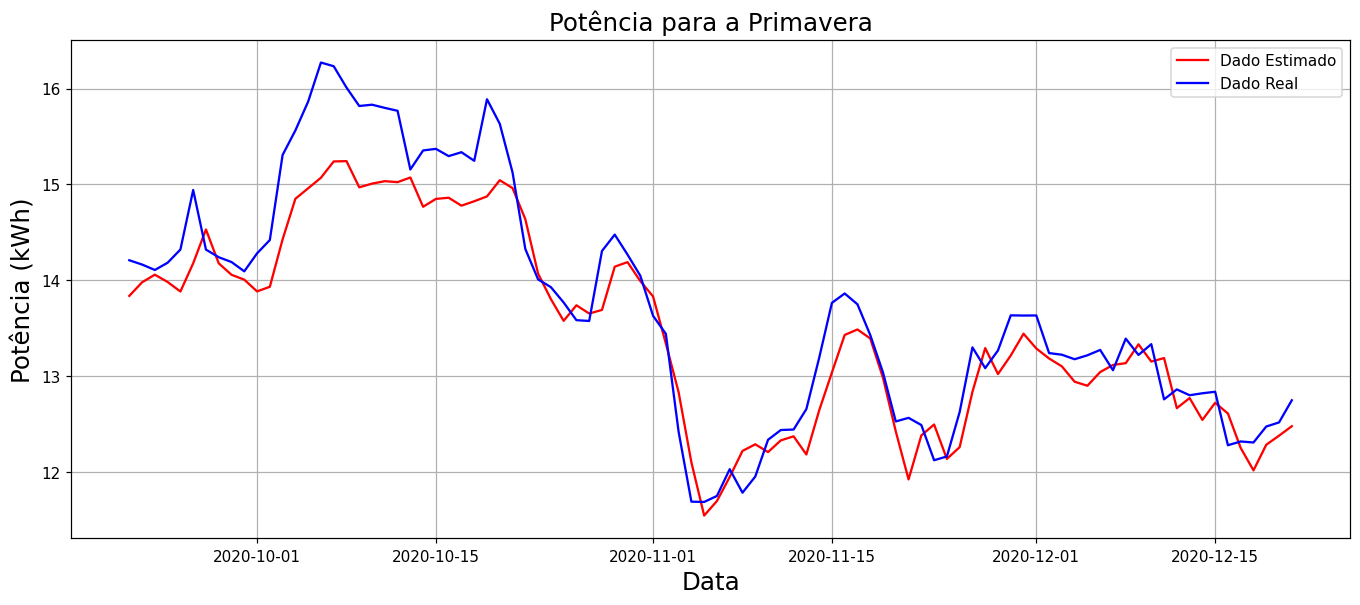

In [81]:
if freq == 'H':
  energia_primavera_pred = primavera_pred['2020-10-22']
  energia_primavera = primavera_original['2020-10-22']
  hr = np.array(energia_primavera.index.time)
  hr = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(hr,energia_primavera['2020-10-22'],'r')
  plt.plot(hr,energia_primavera_pred['2020-10-22'],'b')
  plt.xticks(np.arange(0, len(hr)+1, 1.5))
  plt.text(16,1,'Produção Total de Energia: %.2f kW'%round(energia_primavera.sum(),2),
          fontsize = 14, bbox = dict(facecolor = 'blue', alpha = 0.8))
  arr = energia_primavera_pred.sum()
  plt.text(16,0.8,'Produção Total de Energia:  %.2f kW'%round(arr,2),
          fontsize = 14, bbox = dict(facecolor = 'red', alpha = 0.8))
  plt.xlabel('Horário')
  plt.ylabel('Potência (kW)')
  plt.legend(['Dado Estimado','Dado Real'])
  plt.title('Potência para a Primavera',fontsize=16)
  plt.grid()
  plt.show()
  
elif freq == 'D':
  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(primavera_pred,'r')
  plt.plot(primavera_original,'b')
  plt.xlabel('Data',fontsize=16)
  plt.ylabel('Potência (kWh)',fontsize=16)
  plt.legend(['Dado Estimado','Dado Real'])
  plt.title('Potência para a Primavera',fontsize=16)
  plt.grid()
  plt.show()

In [82]:
if freq == 'H':
  hr = np.array(energia_inverno.index.time)
  hr_inv = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]
  hr = np.array(energia_verao.index.time)
  hr_ver = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]
  hr = np.array(energia_primavera.index.time)
  hr_pri = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]
  hr = np.array(energia_outono.index.time)
  hr_out = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]


  fig, axs = plt.subplots(2, 2,figsize=(18,8))

  fig.suptitle('Geração de Energia por Estação do Ano',fontsize=18)

  axs[0, 0].plot(hr_ver,energia_verao['2021-02-08'],'r',lw=3)
  axs[0, 0].set_title('Verão',fontsize=16)
  axs[1, 0].plot(hr_inv,energia_inverno['2020-06-25'],'r',lw=3)
  axs[1, 0].set_title('Inverno',fontsize=16)
  axs[0, 1].plot(hr_pri,energia_primavera['2020-10-22'],'r',lw=3)
  axs[0, 1].set_title('Primavera',fontsize=16)
  axs[1, 1].plot(hr_out,energia_outono['2020-05-25'],'r',lw=3)
  axs[1, 1].set_title('Outono',fontsize=16)

  plt.sca(axs[0, 0])
  plt.xticks(np.arange(0, len(hr_ver)+1, 2))
  plt.xlabel('Horário',fontsize=14)
  plt.ylabel('Energia (kWh)',fontsize=14)
  plt.grid()
  plt.sca(axs[1, 0])
  plt.xticks(np.arange(0, len(hr_inv)+1, 2))
  plt.xlabel('Horário',fontsize=14)
  plt.ylabel('Energia (kWh)',fontsize=14)
  plt.grid()
  plt.sca(axs[0, 1])
  plt.xticks(np.arange(0, len(hr_pri)+1, 2))
  plt.xlabel('Horário',fontsize=14)
  plt.ylabel('Energia (kWh)',fontsize=14)
  plt.grid()
  plt.sca(axs[1, 1])
  plt.xticks(np.arange(0, len(hr_out)+1, 2))
  plt.xlabel('Horário',fontsize=14)
  plt.ylabel('Energia (kWh)',fontsize=14)
  plt.grid()
  fig.tight_layout()

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.2, 
                      hspace=0.6)



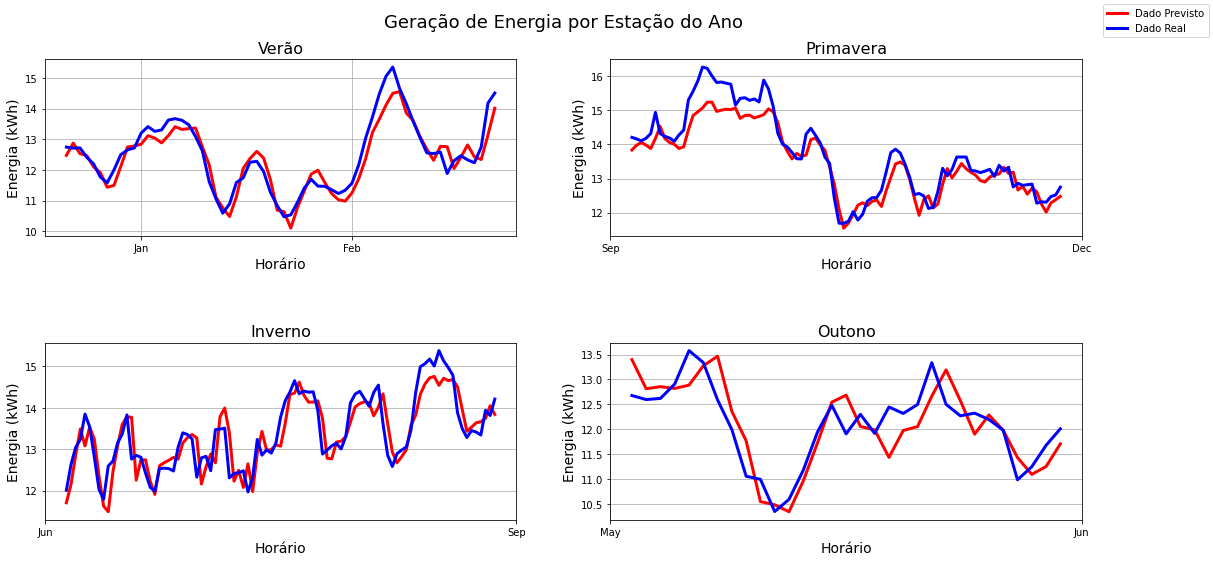

In [83]:
if freq == 'D':
  from matplotlib.dates import MonthLocator, DateFormatter,YearLocator
  from matplotlib.ticker import FuncFormatter

  fig, axs = plt.subplots(2, 2,figsize=(18,8))
  fig.suptitle('Geração de Energia por Estação do Ano',fontsize=18)

  axs[0, 0].plot(verao_pred,'r',verao_original,'b',lw=3)
  axs[0, 0].xaxis.set_major_locator(MonthLocator((1,1.5,2)))
  axs[0, 0].xaxis.set_major_formatter(DateFormatter("%b"))
  axs[0, 0].set_title('Verão',fontsize=16)

  axs[1, 0].plot(inverno_pred,'r',inverno_original,'b',lw=3)
  axs[1, 0].xaxis.set_major_locator(MonthLocator((1,1.5,2)))
  axs[1, 0].xaxis.set_major_formatter(DateFormatter("%b"))
  axs[1, 0].set_title('Inverno',fontsize=16)

  axs[0, 1].plot(primavera_pred,'r',primavera_original,'b',lw=3)
  axs[0, 1].xaxis.set_major_locator(MonthLocator((1,1.5,2)))
  axs[0, 1].xaxis.set_major_formatter(DateFormatter("%b"))
  axs[0, 1].set_title('Primavera',fontsize=16)

  axs[1, 1].plot(outono_pred,'r',outono_original,'b',lw=3)
  axs[1, 1].xaxis.set_major_locator(MonthLocator((1,1.5,2)))
  axs[1, 1].xaxis.set_major_formatter(DateFormatter("%b"))
  axs[1, 1].set_title('Outono',fontsize=16)

  plt.sca(axs[0, 0])
  plt.xlabel('Horário',fontsize=14)
  plt.ylabel('Energia (kWh)',fontsize=14)
  plt.grid()
  plt.sca(axs[1, 0])
  plt.xlabel('Horário',fontsize=14)
  plt.ylabel('Energia (kWh)',fontsize=14)
  plt.grid()
  plt.sca(axs[0, 1])
  plt.xlabel('Horário',fontsize=14)
  plt.ylabel('Energia (kWh)',fontsize=14)
  plt.grid()
  plt.sca(axs[1, 1])
  plt.xlabel('Horário',fontsize=14)
  plt.ylabel('Energia (kWh)',fontsize=14)
  plt.grid()

  fig.tight_layout()
  fig.legend(['Dado Previsto','Dado Real'])


  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.2, 
                      hspace=0.6)

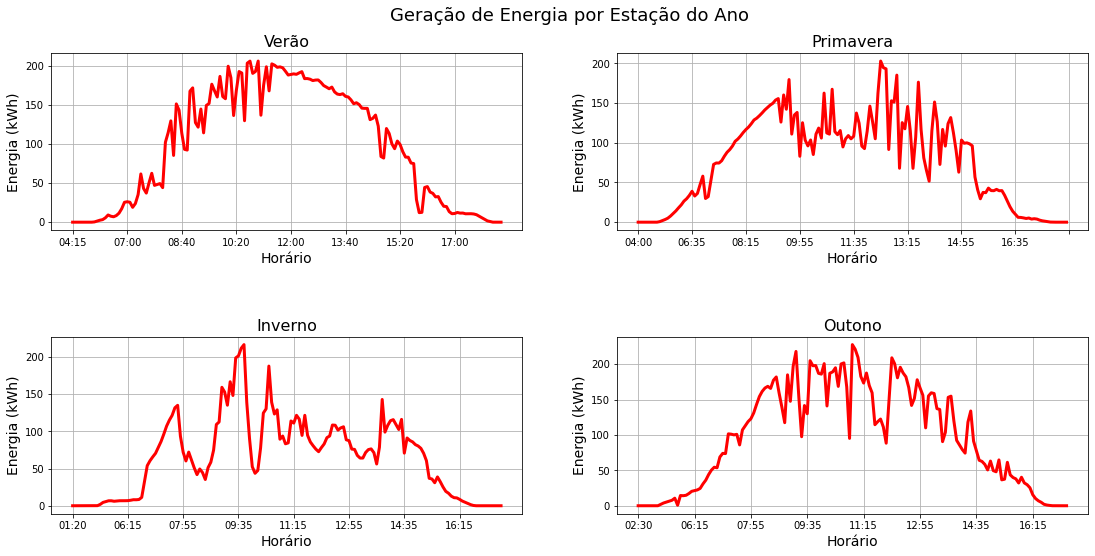

In [84]:
from datetime import datetime

# VERÃO
dia = 5
mes = 2
ano = 2021

start = data_hourly.index.searchsorted(datetime(ano, mes, dia))
end = data_hourly.index.searchsorted(datetime(ano, mes, dia+1))
aux = data_hourly.iloc[start:end]

energia_verao = aux['Energia']
hr = np.array(aux.index.time)
hr_ver = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

fig, axs = plt.subplots(2, 2,figsize=(18,8))

fig.suptitle('Geração de Energia por Estação do Ano',fontsize=18)

axs[0, 0].plot(hr_ver,energia_verao,'r',lw=3)
axs[0, 0].set_title('Verão',fontsize=16)

# INVERNO
dia = 25
mes = 6
ano = 2020

start = data_hourly.index.searchsorted(datetime(ano, mes, dia))
end = data_hourly.index.searchsorted(datetime(ano, mes, dia+1))
aux = data_hourly.iloc[start:end]

energia_inverno = aux['Energia']
hr = np.array(aux.index.time)
hr_inv = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

axs[1, 0].plot(hr_inv,energia_inverno,'r',lw=3)
axs[1, 0].set_title('Inverno',fontsize=16)

# PRIMAVERA
dia = 25
mes = 11
ano = 2020

start = data_hourly.index.searchsorted(datetime(ano, mes, dia))
end = data_hourly.index.searchsorted(datetime(ano, mes, dia+1))
aux = data_hourly.iloc[start:end]

energia_primavera = aux['Energia']
hr = np.array(aux.index.time)
hr_pri = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

axs[0, 1].plot(hr_pri,energia_primavera,'r',lw=3)
axs[0, 1].set_title('Primavera',fontsize=16)

# OUTONO
dia = 15
mes = 4
ano = 2020

start = data_hourly.index.searchsorted(datetime(ano, mes, dia))
end = data_hourly.index.searchsorted(datetime(ano, mes, dia+1))
aux = data_hourly.iloc[start:end]

energia_outono = aux['Energia']
hr = np.array(aux.index.time)
hr_out = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

axs[1, 1].plot(hr_out,energia_outono,'r',lw=3)
axs[1, 1].set_title('Outono',fontsize=16)

plt.sca(axs[0, 0])
plt.xticks(np.arange(0, len(hr_ver)+1, 20))
plt.xlabel('Horário',fontsize=14)
plt.ylabel('Energia (kWh)',fontsize=14)
plt.grid()
plt.sca(axs[1, 0])
plt.xticks(np.arange(0, len(hr_inv)+1, 20))
plt.xlabel('Horário',fontsize=14)
plt.ylabel('Energia (kWh)',fontsize=14)
plt.grid()
plt.sca(axs[0, 1])
plt.xticks(np.arange(0, len(hr_pri)+1, 20))
plt.xlabel('Horário',fontsize=14)
plt.ylabel('Energia (kWh)',fontsize=14)
plt.grid()
plt.sca(axs[1, 1])
plt.xticks(np.arange(0, len(hr_out)+1, 20))
plt.xlabel('Horário',fontsize=14)
plt.ylabel('Energia (kWh)',fontsize=14)
plt.grid()
fig.tight_layout()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)


In [85]:
print('predição verão = {} kW'.format(round(data_hourly_plot['predicoes']['2021-02-22'].sum()/1e3,2)))
print('original verão = {} kW'.format(round(data_hourly_plot['original']['2021-02-22'].sum()/1e3,2)))              

print('predição outono = {} kW'.format(round(data_hourly_plot['predicoes']['2020-05-25'].sum()/1e3,2)))
print('original outono = {} kW'.format(round(data_hourly_plot['original']['2020-05-25'].sum()/1e3,2)))

print('predição primavera = {} kW'.format(round(data_hourly_plot['predicoes']['2020-10-22'].sum()/1e3,2)))
print('original primavera = {} kW'.format(round(data_hourly_plot['original']['2020-10-22'].sum()/1e3,2)))

print('predição inverno = {} kW'.format(round(data_hourly_plot['predicoes']['2020-06-25'].sum()/1e3,2)))
print('original inverno = {} kW'.format(round(data_hourly_plot['original']['2020-06-25'].sum()/1e3,2)))


predição verão = 14.02 kW
original verão = 14.51 kW
predição outono = 12.82 kW
original outono = 12.91 kW
predição primavera = 14.64 kW
original primavera = 14.33 kW
predição inverno = 13.08 kW
original inverno = 13.85 kW


Text(0, 0.5, 'Densidade')

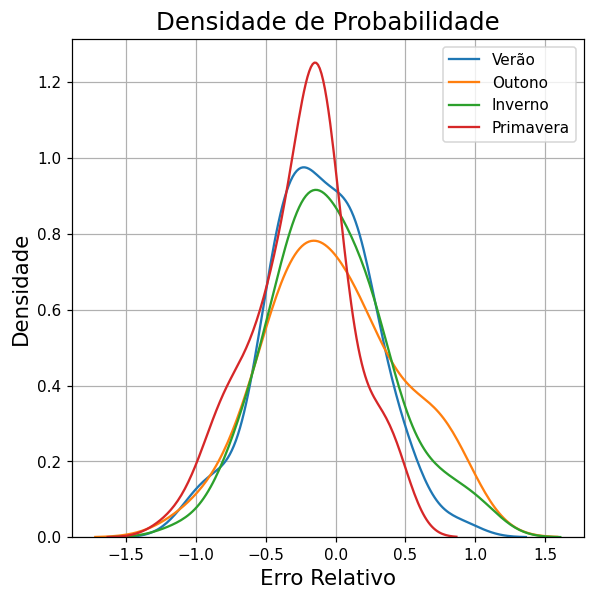

In [86]:
plt.figure(figsize=(6,6),dpi=110)
plt.grid()
sns.kdeplot(verao_pred-verao_original)
sns.kdeplot(outono_pred-outono_original)
sns.kdeplot(inverno_pred-inverno_original)
sns.kdeplot(primavera_pred-primavera_original)
plt.legend(['Verão','Outono','Inverno','Primavera'])
plt.title('Densidade de Probabilidade',fontsize=16)
plt.xlabel('Erro Relativo',fontsize=14)
plt.ylabel('Densidade',fontsize=14)

## DROPOUT

In [87]:
if altera_param == 'y':
  if parameter == 1:
    T = 1000 #quantidade_de_passos
    l = np.array([0.001,0.01,0.1,1,10]) #length scale
    N = input_train.shape[0] #quantidade de dados de treinamento

    #Dropout
    p_input = 0.0 #probabilidadde de desativação na camada de entrada
    p = 0.5 #probabilidade de desativação nas camadas escondidas 

    #Peso da regularização L2
    lbd = 1e-4
    #l2 = keras.regularizers.L2(lbd)

    #Precisão do modelo
    tau = l**2 *(1-p) / (2*N*lbd) 
  
  elif parameter == 2:
    T = 1000 #quantidade_de_passos
    l = 0.1 #length scale
    N = input_train.shape[0] #quantidade de dados de treinamento

    #Dropout
    p_input = 0.0 #probabilidadde de desativação na camada de entrada
    p = np.array([0.1,0.2,0.3,0.4,0.5]) #probabilidade de desativação nas camadas escondidas 

    #Peso da regularização L2
    lbd = 1e-4
    #l2 = keras.regularizers.L2(lbd)

    #Precisão do modelo
    tau = l**2 *(1-p) / (2*N*lbd)

  elif parameter == 3:
    T = 1000 #quantidade_de_passos
    l = 0.1 #length scale
    N = input_train.shape[0] #quantidade de dados de treinamento

    #Dropout
    p_input = 0.0 #probabilidadde de desativação na camada de entrada
    p = 0.5 #probabilidade de desativação nas camadas escondidas 

    #Peso da regularização L2
    lbd = np.array([1e-6,1e-5,1e-4,1e-3,1e-2])
    #l2 = keras.regularizers.L2(lbd)

    #Precisão do modelo
    tau = l**2 *(1-p) / (2*N*lbd)

elif altera_param == 'n':
  T = 1000 #quantidade_de_passos
  l = 0.1 #length scale
  N = input_train.shape[0] #quantidade de dados de treinamento

  #Dropout
  p_input = 0.0 #probabilidadde de desativação na camada de entrada
  p = 0.5 #probabilidade de desativação nas camadas escondidas 

  #Peso da regularização L2
  lbd = 1e-4
  #l2 = keras.regularizers.L2(lbd)

  #Precisão do modelo
  tau = l**2 *(1-p) / (2*N*lbd)

In [88]:
def create_model_dp(inputs,outputs,activation_fn,n_neurons,p_input,p,lbd):

  model_dp = keras.Sequential([
    keras.Input(len(inputs.columns),),  # input layer (1)
    keras.layers.Dropout(p_input),
    keras.layers.Dense(n_neurons, activation=activation_fn,
                       kernel_regularizer = keras.regularizers.L2(lbd)),
                       #bias_regularizer= l2,
                       #activity_regularizer= l2,  # hidden layer (1)
    #keras.layers.Dropout(0.2),
    keras.layers.Dropout(p),
    keras.layers.Dense(n_neurons, activation=activation_fn,
                       kernel_regularizer = keras.regularizers.L2(lbd)),
                       #bias_regularizer = l2,
                       #activity_regularizer = l2),  # hidden layer (1)
    #keras.layers.Dropout(0.2),
    # keras.layers.Dense(25, activation='relu',                    
    #                    bias_regularizer=regularizers.l2(1e-4),
    #                    activity_regularizer=regularizers.l2(1e-5)),  # hidden layer (1)
    #keras.layers.Dropout(0.2),
    keras.layers.Dropout(p),
    keras.layers.Dense(len(outputs.columns), activation=None) # output layer 
    
  ])
  return model_dp



In [89]:
n_neurons = 50
activation_fn = 'tanh'

model_dp = create_model_dp(inputs,outputs,activation_fn,n_neurons,p_input,0.5,1e-4)

model_dp.compile(optimizer ='adam',
              loss='mse',
              metrics=['mae'])

model_dp.summary()

#early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',mode='min',patience = 10)

if freq == 'D':
  h = model_dp.fit(entrada_train, saida_train, shuffle=True, epochs=500,
                      validation_data=(entrada_test, saida_test))
elif freq == 'H':
  h = model_dp.fit(entrada_train, saida_train, shuffle=True, epochs=500,
                      validation_data=(entrada_test, saida_test),callbacks=early_stop)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                2450      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,051
Trainable params: 5,051
Non-traina

###Avaliação dos Resultados

In [90]:
test_loss, test_mae = model_dp.evaluate(entrada_test, saida_test, verbose=1) 

#print('Test accuracy:', test_acc) 

9/9 [==============================] - 0s 1ms/step - loss: 0.0037 - mae: 0.0372


#### R2 Score

In [91]:
y_hat_train_dp = model_dp.predict(input_train)
print(metrics.r2_score(output_train, y_hat_train_dp))

y_hat_test_dp = model_dp.predict(input_test)
print(metrics.r2_score(output_test, y_hat_test_dp))

0.9280057447854855
0.9034459498252556


Text(0, 0.5, 'Loss')

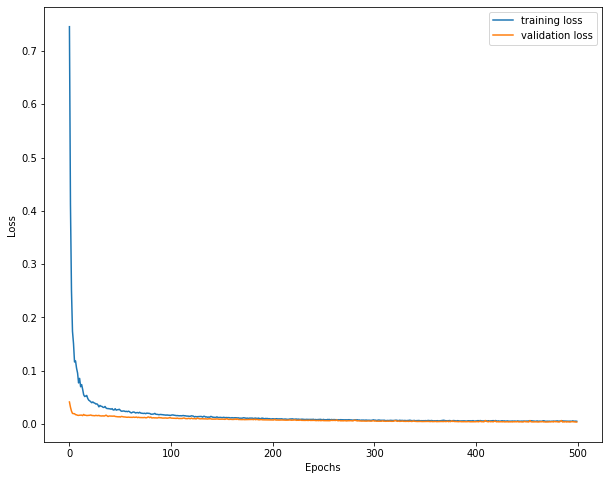

In [92]:
plt.figure(figsize=(10,8))
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xlim([0,100])

In [93]:
predictions_dp = model_dp.predict(entrada_test)

### Função de Monte Carlo

In [94]:
#iremos performar model qtd_passsos vezes
#a flag training é setada em True para que o Dropout ocorra durante a inferência
#a função retorna a média e a variância do array preds 

def predict_MC(X, model, qtd_passos):
    preds = np.array([model_dp(X, training=True) for _ in range(qtd_passos)])
    preds_d = Denormalize(preds, outputs.iloc[:,0]) #desnormalizando saídas
    return preds_d.mean(axis=0), preds_d.var(axis=0)
    

In [95]:
#média e variância dos T passos para cada ponto do treinamento
if altera_param == 'y':
  if parameter == 1:
    y_mean = np.zeros((predictions_dp.shape[0],1))
    y_var = np.zeros((predictions_dp.shape[0],1))

    for i in l:
      n_neurons = 50
      activation_fn = 'tanh'
      model_dp = create_model_dp(inputs,outputs,activation_fn,n_neurons,p_input,p,lbd)
      model_dp.compile(optimizer ='adam',
                  loss='mse',
                  metrics=['mae'])

      early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',mode='min',patience = 10)
      print('----------------------------length scale = {} -----------------------------'.format(i))

      if freq == 'D':
        h = model_dp.fit(entrada_train, saida_train, shuffle=True, epochs=500,
                            validation_data=(entrada_test, saida_test))
      elif freq == 'H':
        h = model_dp.fit(entrada_train, saida_train, shuffle=True, epochs=1000,
                            validation_data=(entrada_test, saida_test),callbacks=early_stop)
      
      y_mean_temp, y_var_temp = predict_MC(input_test, model_dp, T)

      y_mean = np.append(y_mean,y_mean_temp,axis=1)
      y_var = np.append(y_var,y_var_temp,axis=1)
    
  elif parameter == 2:
    y_mean = np.zeros((predictions_dp.shape[0],1))
    y_var = np.zeros((predictions_dp.shape[0],1))

    for i in p:
      n_neurons = 50
      activation_fn = 'tanh'
      model_dp = create_model_dp(inputs,outputs,activation_fn,n_neurons,p_input,i,lbd)
      model_dp.compile(optimizer ='adam',
                       loss='mse',
                       metrics=['mae'])
       
      early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',mode='min',patience = 10)

      print('----------------------------probabilidade de dropout = {} -----------------------------'.format(i))

      if freq == 'D':
        h = model_dp.fit(entrada_train, saida_train, shuffle=True, epochs=500,
                            validation_data=(entrada_test, saida_test))
      elif freq == 'H':
        h = model_dp.fit(entrada_train, saida_train, shuffle=True, epochs=500,
                            validation_data=(entrada_test, saida_test),callbacks=early_stop)
        
      y_mean_temp, y_var_temp = predict_MC(input_test, model_dp, T)

      y_mean = np.append(y_mean,y_mean_temp,axis=1)
      y_var = np.append(y_var,y_var_temp,axis=1)

  elif parameter == 3:
    y_mean = np.zeros((predictions_dp.shape[0],1))
    y_var = np.zeros((predictions_dp.shape[0],1))

    for i in lbd:
      n_neurons = 50
      activation_fn = 'tanh'
      model_dp = create_model_dp(inputs,outputs,activation_fn,n_neurons,p_input,p,i)
      model_dp.compile(optimizer ='adam',
                       loss='mse',
                       metrics=['mae'])
       
      early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',mode='min',patience = 10)

      print('----------------------------Peso da regularização L2 = {} -----------------------------'.format(i))

      if freq == 'D':
        h = model_dp.fit(entrada_train, saida_train, shuffle=True, epochs=500,
                            validation_data=(entrada_test, saida_test))
      elif freq == 'H':
        h = model_dp.fit(entrada_train, saida_train, shuffle=True, epochs=1000,
                            validation_data=(entrada_test, saida_test),callbacks=early_stop)
        
      y_mean_temp, y_var_temp = predict_MC(input_test, model_dp, T)

      y_mean = np.append(y_mean,y_mean_temp,axis=1)
      y_var = np.append(y_var,y_var_temp,axis=1)

elif altera_param == 'n':
  y_mean, y_var = predict_MC(input_test, model_dp, T)


In [96]:
if altera_param == 'y':
  y_mean = np.delete(y_mean,0,axis=1)
  y_var = np.delete(y_var,0,axis=1)


In [97]:
#Capturando a incerteza do modelo
y_inc = y_var + tau**-1

In [98]:
#Desnormalizando target
ypd = Denormalize(output_test, outputs['Energia(k+1)'])
ypd = np.array(ypd)

In [99]:
#obtendo algumas métricas
MAPE = keras.metrics.mean_absolute_percentage_error(ypd,y_mean)
MSE = keras.metrics.mean_squared_error(ypd, y_mean)
MAE = keras.metrics.mean_absolute_error(ypd,y_mean)
RMSE = np.sqrt(keras.metrics.mean_squared_error(ypd,y_mean))
sMAPE = sMAPE_fn(ypd,y_mean)

print(f'RMSE= {np.mean(RMSE)}')
print(f'MAE= {np.mean(MAE)}')
print(f'MSE= {np.mean(MSE)}')
print(f'MAPE= {np.mean(MAPE)}%')
print(f'sMAPE= {np.mean(sMAPE)}%')

RMSE= 287.2983703613281
MAE= 287.2983703613281
MSE= 139378.09375
MAPE= 2.219085454940796%
sMAPE= 1.1025397252670954%


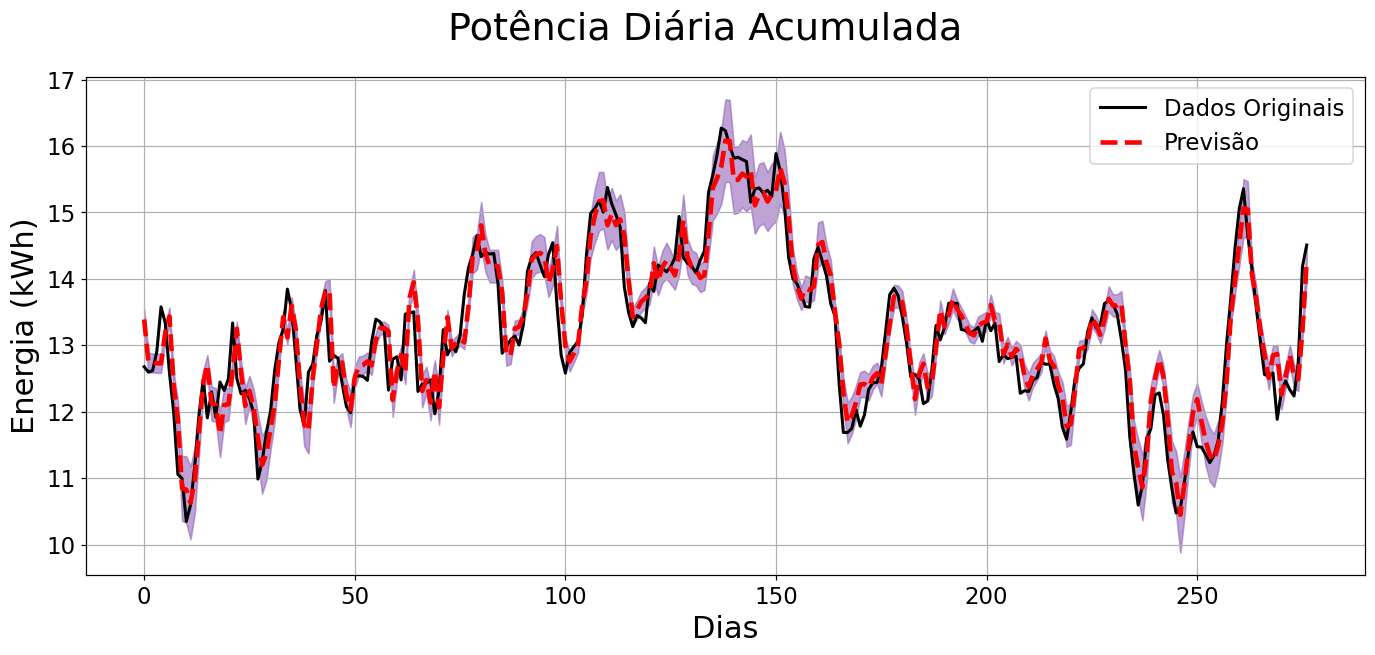

In [100]:
#criando parâmetros para construir o gráfico
t = np.arange(y_mean.shape[0])
mu = y_mean/1e3 #média da previsão de 1 semana pra frente
sigma = np.sqrt(y_inc)/1e3 #variância da previsão de 1 semana pra frente

#if altera_param == 'n':
mu = y_mean[:,0]/1e3 #média da previsão de 1 semana pra frente
sigma = np.sqrt(y_inc[:,0])/1e3 #variância da previsão de 1 semana pra frente

fig = plt.figure(figsize=(15,6),dpi=110)
plt.suptitle("Potência Diária Acumulada", size=25)
 
plt.plot(t, ypd[:,0]/1e3, color="black",label="Dados Originais", lw=2)
plt.plot(t, mu, '--', color='red', label="Previsão", lw=3)

for shade in range(1,5):
  plt.fill_between(t, mu+sigma, mu-sigma, alpha=0.2, color='C4')  
    
plt.tick_params(axis='both', labelsize=15)
plt.ylabel('Energia (kWh)',size=20)
plt.xlabel('Dias',size=20)
plt.grid(True)
plt.legend(fontsize=15)

####Estações do ano

#####Criação dos Data Frames

In [101]:
sd_data_hourly = pd.DataFrame(ypd)
sd_data_hourly.columns=['original']
aux = output_test.reset_index()
data_hourly_plot_dp = pd.concat([sd_data_hourly,aux],axis=1)
data_hourly_plot_dp.set_index(['DATA'],inplace=True)
data_hourly_plot_dp.drop(['Energia(k+1)'], axis=1,inplace=True)
data_hourly_plot_dp

,original
DATA,
2020-05-22,12677.383333
2020-05-23,12595.885000
2020-05-24,12619.223333
2020-05-25,12908.156667
2020-05-26,13578.506667
...,...
2021-02-18,12330.378333
2021-02-19,12236.911667
2021-02-20,12746.933333


In [102]:
pred_data_hourly = pd.DataFrame(y_mean/1e3)
aux = output_test.reset_index()
x = pd.concat([aux,pred_data_hourly],axis=1)
x.set_index(['DATA'],inplace=True)
x.drop(['Energia(k+1)'], axis=1,inplace=True)
pred_data_hourly = x
pred_data_hourly

,0
DATA,
2020-05-22,13.388772
2020-05-23,12.745190
2020-05-24,12.730577
2020-05-25,12.731790
2020-05-26,12.727680
...,...
2021-02-18,12.857206
2021-02-19,12.528543
2021-02-20,12.489495


In [103]:
sigma_data_hourly = pd.DataFrame(np.sqrt(y_inc))
aux = output_test.reset_index()
x = pd.concat([aux,sigma_data_hourly],axis=1)
x.set_index(['DATA'],inplace=True)
x.drop(['Energia(k+1)'], axis=1,inplace=True)
sigma_data_hourly = x
sigma_data_hourly

,0
DATA,
2020-05-22,148.045334
2020-05-23,149.440155
2020-05-24,140.058273
2020-05-25,145.754639
2020-05-26,142.511383
...,...
2021-02-18,147.138718
2021-02-19,176.279892
2021-02-20,175.980194


In [104]:
MAPE = keras.metrics.mean_absolute_percentage_error(predictions_dp,output_test)
MAE = keras.metrics.mean_absolute_error(predictions_dp,output_test)
MSE = keras.metrics.mean_squared_error(predictions_dp,output_test)
RMSE = np.sqrt(keras.metrics.mean_squared_error(predictions_dp,output_test))
sMAPE = sMAPE_fn(predictions_dp,output_test)

print('MAE: ',np.mean(MAE))
print('MAPE: ',np.mean(MAPE))
print('sMAPE: ',np.mean(sMAPE))
print('MSE: ',np.mean(MSE))
print('RMSE: ',np.mean(RMSE))

MAE:  0.03723556194446802
MAPE:  6.7997561288665365
sMAPE:  3.4708998982576684
MSE:  0.0023480721938506223
RMSE:  0.03723556194446802


#####Verão

In [105]:
verao_mu1 = pred_data_hourly['2020-12-21':'2021-02-21']
verao_sigma1 = sigma_data_hourly['2020-12-21':'2021-02-21']/1e3
verao_original1 = data_hourly_plot_dp['original']['2020-12-21':'2021-02-21']/1e3

if altera_param == 'n':
  MAPE = keras.metrics.mean_absolute_percentage_error(verao_original,verao_mu1)
  MAE = keras.metrics.mean_absolute_error(verao_original,verao_mu1)
  MSE = keras.metrics.mean_squared_error(verao_original,verao_mu1)
  sMAPE = sMAPE_fn(np.array(verao_original1),np.array(verao_mu1))

  print('RMSE Verão: ', np.sqrt(np.mean(MSE)))
  print('MAE Verão: ', np.mean(MAE))
  print(f'MAPE Verão: {np.mean(MAPE)} %')
  print(f'sMAPE Verão: {np.mean(sMAPE)} %')

RMSE Verão:  1.5005744
MAE Verão:  1.2027006
MAPE Verão: 9.69560718536377 %
sMAPE Verão: 298.8792102183147 %


In [106]:
line_types = ['--','-o','-o','-*',':']
line_colors = ['red','blue','green','orange','gray']

In [107]:
if freq == 'H':
  dia = '2021-02-05'
  verao_mu = verao_mu1[dia]
  verao_sigma = verao_sigma1[dia]
  verao_original = verao_original1[dia]

  hr = np.array(verao_original.index.time)
  hr = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(hr,verao_original[dia],'black')
  plt.xticks(np.arange(0, len(hr)+1, 3))

  if altera_param == 'n':
    plt.plot(hr,verao_mu[dia],'r--')
    
    verao_mu = np.array(verao_mu)
    verao_sigma = np.array(verao_sigma)
    for shade in range(0,len(line_types)):
      plt.fill_between(hr,verao_mu[:,0]+verao_sigma[:,0],verao_mu[:,0]-verao_sigma[:,0]
                       ,alpha=0.2, color='C4')

  if altera_param == 'y':    
    for k in range(0,len(line_types)):
      plt.plot(hr,verao_mu[dia][k],line_types[k],color = line_colors[k],lw=3)

    if parameter == 1:
      leg1 = plt.legend(['Real','Previsão para l = 0.001','Previsão para l = 0.01',
                          'Previsão para l = 0.1','Previsão para l = 1','Previsão para l = 10'])
    elif parameter == 2:
      leg1 = plt.legend(['Real','Previsão para p=10%','Previsão para p=20%',
                        'Previsão para p=30%','Previsão para p=40%','Previsão para p=50%'])
    elif parameter == 3:
      leg1 = plt.legend(['Real','Previsão para peso = 1e-6','Previsão para peso = 1e-5',
                          'Previsão para peso = 1e-4','Previsão para peso = 1e-3','Previsão para peso = 1e-2'])

    verao_mu = np.array(verao_mu)
    verao_sigma = np.array(verao_sigma)

    for shade in range(0,len(line_colors)):
      i = 1/(1+shade)
      if parameter == 1:
         plt.fill_between(hr,verao_mu[:,shade]+verao_sigma[:,shade],verao_mu[:,shade]-verao_sigma[:,shade], 
                          alpha=i, color='C{}'.format(shade+1),label='Incerteza para l = {}'.format(l[shade]))

      elif parameter == 2:
         plt.fill_between(hr,verao_mu[:,shade]+verao_sigma[:,shade],verao_mu[:,shade]-verao_sigma[:,shade], 
                          alpha=i, color='C4',label='Incerteza para {}%'.format((shade+1)*10))
          
      elif parameter == 3:
         plt.fill_between(hr,verao_mu[:,shade]+verao_sigma[:,shade],verao_mu[:,shade]-verao_sigma[:,shade], 
                          alpha=i, color='C4',label='Incerteza para peso = 1e-{}'.format((len(lbd)-shade)))
        
      plt.legend(loc='upper left')
      plt.gca().add_artist(leg1)
      
  plt.xlabel('Horário')
  plt.ylabel('Energia (kWh)')
  plt.title('Previsão para o Verão',fontsize=16)
  plt.grid()
  plt.show()



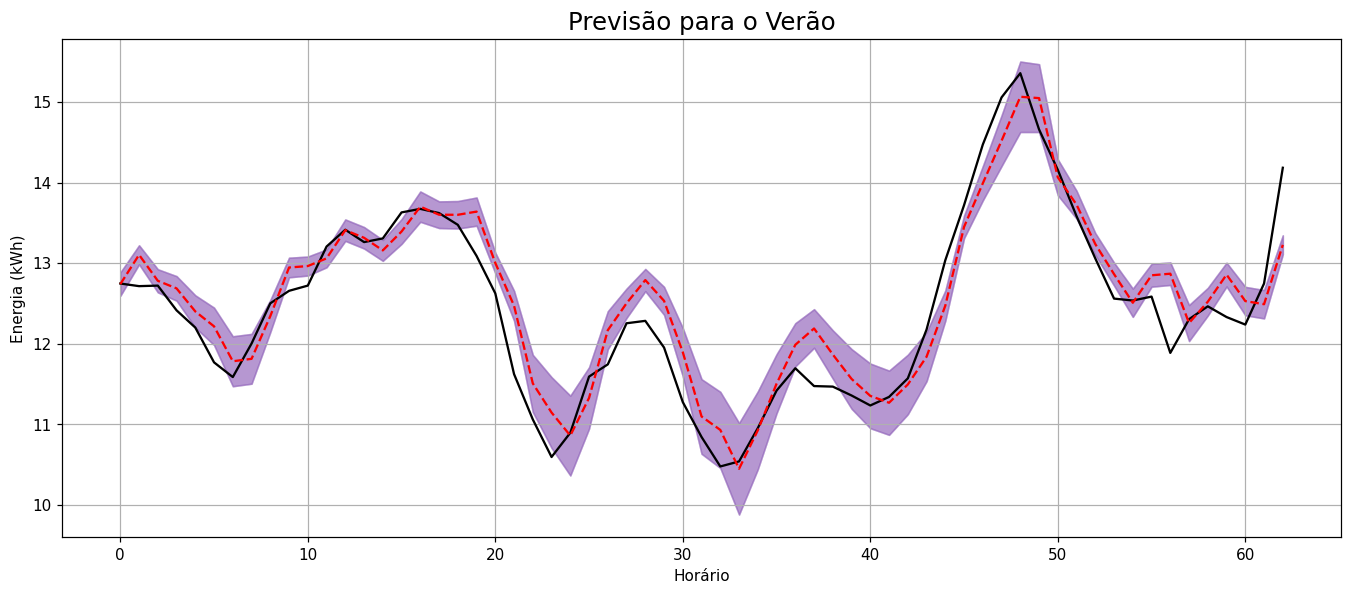

In [108]:
if freq == 'D':

  verao_mu = verao_mu1['2020-12-21':'2021-02-21']
  verao_sigma = verao_sigma1['2020-12-21':'2021-02-21']
  verao_original = verao_original1['2020-12-21':'2021-02-21']

  t = np.arange(verao_original.shape[0])

  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(t,verao_original['2020-12-21':'2021-02-21'],'black')
  
  if altera_param == 'n':
    plt.plot(t,verao_mu['2020-12-21':'2021-02-21'],'r--')
    
    verao_mu = np.array(verao_mu)
    verao_sigma = np.array(verao_sigma)
    
    for shade in range(0,len(line_types)):
      plt.fill_between(t,verao_mu[:,0]+verao_sigma[:,0],verao_mu[:,0]-verao_sigma[:,0]
                       ,alpha=0.2, color='C4')

  if altera_param == 'y':    
    for k in range(0,len(line_types)):
      plt.plot(t,verao_mu['2020-12-21':'2021-02-21'][k],line_types[k],color = line_colors[k],lw=3)

    if parameter == 1:
      leg1 = plt.legend(['Real','Previsão para l = 0.001','Previsão para l = 0.01',
                          'Previsão para l = 0.1','Previsão para l = 1','Previsão para l = 10'])
    elif parameter == 2:
      leg1 = plt.legend(['Real','Previsão para p=10%','Previsão para p=20%',
                        'Previsão para p=30%','Previsão para p=40%','Previsão para p=50%'])
    elif parameter == 3:
      leg1 = plt.legend(['Real','Previsão para peso = 1e-6','Previsão para peso = 1e-5',
                          'Previsão para peso = 1e-4','Previsão para peso = 1e-3','Previsão para peso = 1e-2'])

    verao_mu = np.array(verao_mu)
    verao_sigma = np.array(verao_sigma)

    for shade in range(0,len(line_colors)):
      i = 1/(1+shade)
      if parameter == 1:
         plt.fill_between(t,verao_mu[:,shade]+verao_sigma[:,shade],verao_mu[:,shade]-verao_sigma[:,shade], 
                          alpha=i, color='C{}'.format(shade+1),label='Incerteza para l = {}'.format(l[shade]))

      elif parameter == 2:
         plt.fill_between(t,verao_mu[:,shade]+verao_sigma[:,shade],verao_mu[:,shade]-verao_sigma[:,shade], 
                          alpha=i, color='C4',label='Incerteza para {}%'.format((shade+1)*10))
          
      elif parameter == 3:
         plt.fill_between(t,verao_mu[:,shade]+verao_sigma[:,shade],verao_mu[:,shade]-verao_sigma[:,shade], 
                          alpha=i, color='C4',label='Incerteza para peso = 1e-{}'.format((len(lbd)-shade)))
        
      plt.legend(loc='lower left')
      plt.gca().add_artist(leg1)

  plt.xlabel('Horário')
  plt.ylabel('Energia (kWh)')
  plt.title('Previsão para o Verão',fontsize=16)
  #plt.xlim([0,3])
  plt.grid()
  plt.show()


#####Outono

In [109]:
outono_mu1 = pred_data_hourly['2020-03-21':'2020-06-21']
outono_sigma1 = sigma_data_hourly['2020-03-21':'2020-06-21']/1e3
outono_original1 = data_hourly_plot_dp['original']['2020-03-21':'2020-06-21']/1e3

if altera_param == 'n':
  MAPE = keras.metrics.mean_absolute_percentage_error(outono_original,outono_mu1)
  MAE = keras.metrics.mean_absolute_error(outono_original,outono_mu1)
  MSE = keras.metrics.mean_squared_error(outono_original,outono_mu1)
  sMAPE = sMAPE_fn(np.array(outono_original1),np.array(outono_mu1))

  print('RMSE Outono: ', np.sqrt(np.mean(MSE)))
  print('MAE Outono: ', np.mean(MAE))
  print(f'MAPE Outono: {np.mean(MAPE)} %')
  print(f'sMAPE Outono: {np.mean(sMAPE)} %')

RMSE Outono:  1.0782403
MAE Outono:  0.8623405
MAPE Outono: 7.241140365600586 %
sMAPE Outono: 111.2132210391084 %


In [110]:
if freq == 'H':
  outono_mu = outono_mu1['2020-05-25']
  outono_sigma = outono_sigma1['2020-05-25']
  outono_original = outono_original1['2020-05-25']

  hr = np.array(outono_original.index.time)
  hr = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.xticks(np.arange(0, len(hr)+1, 3))
  plt.plot(hr,outono_original['2020-05-25'],'black')

  if altera_param == 'n':
    plt.plot(hr,outono_mu['2020-05-25'],'r--')
    
    outono_mu = np.array(outono_mu)
    outono_sigma = np.array(outono_sigma)
    for shade in range(0,len(line_types)):
      plt.fill_between(hr,outono_mu[:,0]+outono_sigma[:,0],outono_mu[:,0]-outono_sigma[:,0]
                       ,alpha=0.2, color='C4')
      
  if altera_param == 'y':    
    for k in range(0,len(line_types)):
      plt.plot(hr,outono_mu['2020-05-25'][k],line_types[k],color = line_colors[k],lw=3)

    if parameter == 1:
      leg1 = plt.legend(['Real','Previsão para l = 0.001','Previsão para l = 0.01',
                        'Previsão para l = 0.1','Previsão para l = 1','Previsão para l = 10'])
    elif parameter == 2:
      leg1 = plt.legend(['Real','Previsão para p=10%','Previsão para p=20%',
                      'Previsão para p=30%','Previsão para p=40%','Previsão para p=50%'])
    elif parameter == 3:
      leg1 = plt.legend(['Real','Previsão para peso = 1e-6','Previsão para peso = 1e-5',
                        'Previsão para peso = 1e-4','Previsão para peso = 1e-3','Previsão para peso = 1e-2'])

    outono_sigma = np.array(outono_sigma)
    outono_mu = np.array(outono_mu)

    for shade in range(0,len(line_types)):
      i = 1/(1+shade)
      if parameter == 2:
        plt.fill_between(hr,outono_mu[:,shade]+outono_sigma[:,shade],outono_mu[:,shade]-outono_sigma[:,shade], 
                        alpha=i, color='C4',label='Incerteza para {}%'.format((shade+1)*10))

      elif parameter == 3:
        plt.fill_between(hr,outono_mu[:,shade]+outono_sigma[:,shade],outono_mu[:,shade]-outono_sigma[:,shade], 
                        alpha=i, color='C4',label='Incerteza para peso = 1e-{}'.format((len(lbd)-shade)))
      elif parameter == 1:
        plt.fill_between(hr,outono_mu[:,shade]+outono_sigma[:,shade],outono_mu[:,shade]-outono_sigma[:,shade], 
                      alpha=i, color='C{}'.format(shade+1),label='Incerteza para l = {}'.format(l[shade]))
      
    plt.legend(loc='upper left')
    plt.gca().add_artist(leg1)

  plt.xlabel('Horário')
  plt.ylabel('Energia (kWh)')
  plt.title('Previsão para o Outono',fontsize=16)
  plt.grid()
  plt.show()



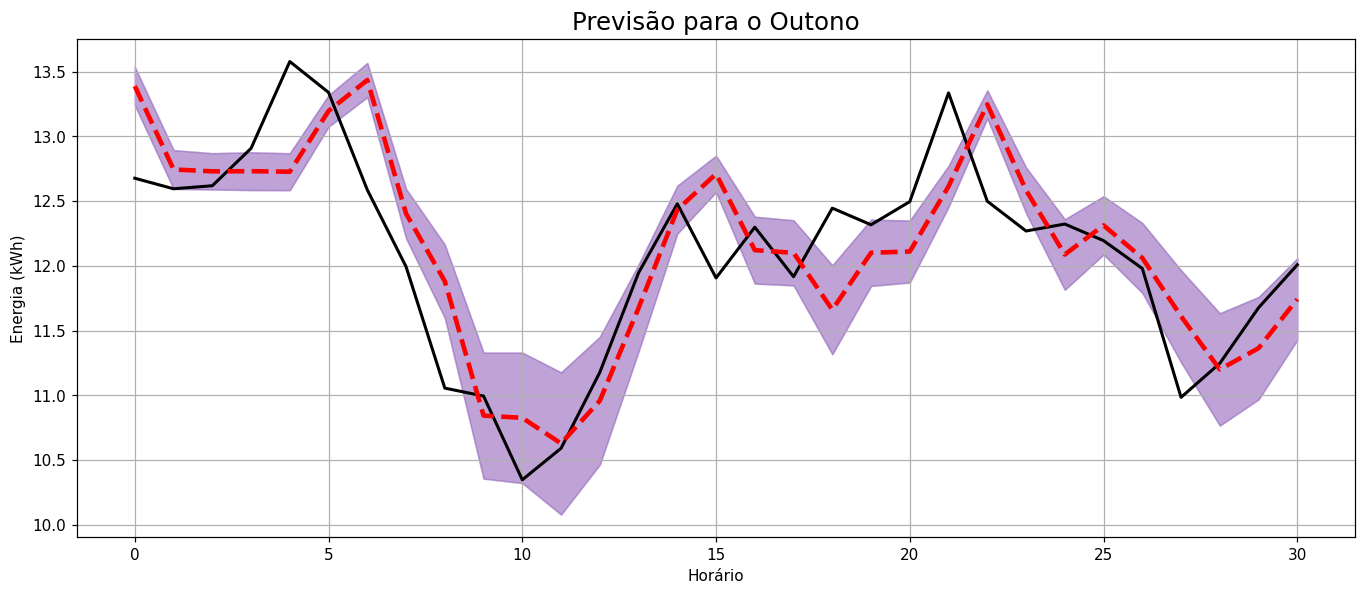

In [111]:
if freq == 'D':

  outono_mu = outono_mu1['2020-03-21':'2020-06-21']
  outono_sigma = outono_sigma1['2020-03-21':'2020-06-21']
  outono_original = outono_original1['2020-03-21':'2020-06-21']
  t = np.arange(outono_original.shape[0])
  
  fig_incerteza = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(t,outono_original, color="black", label="Real", lw=2)

  if altera_param == 'n':
    plt.plot(t,outono_mu, '--', color='red', label="Previsão", lw=3)
    outono_mu = np.array(outono_mu)
    outono_sigma = np.array(outono_sigma)

    for shade in range(1,5):
      plt.fill_between(t,outono_mu[:,0]+outono_sigma[:,0],outono_mu[:,0]-outono_sigma[:,0],
                       alpha=0.2, color='C4')

  if altera_param == 'y':    
    for k in range(0,len(line_types)):
      plt.plot(t,outono_mu['2020-03-21':'2020-06-21'][k],line_types[k],color = line_colors[k],lw=3)

    if parameter == 1:
      leg1 = plt.legend(['Real','Previsão para l = 0.001','Previsão para l = 0.01',
                        'Previsão para l = 0.1','Previsão para l = 1','Previsão para l = 10'])
    elif parameter == 2:
      leg1 = plt.legend(['Real','Previsão para p=10%','Previsão para p=20%',
                      'Previsão para p=30%','Previsão para p=40%','Previsão para p=50%'])
    elif parameter == 3:
      leg1 = plt.legend(['Real','Previsão para peso = 1e-6','Previsão para peso = 1e-5',
                        'Previsão para peso = 1e-4','Previsão para peso = 1e-3','Previsão para peso = 1e-2'])

    outono_sigma = np.array(outono_sigma)
    outono_mu = np.array(outono_mu)

    for shade in range(0,len(line_types)):
      i = 1/(1+shade)
      if parameter == 2:
        plt.fill_between(t,outono_mu[:,shade]+outono_sigma[:,shade],outono_mu[:,shade]-outono_sigma[:,shade], 
                        alpha=i, color='C4',label='Incerteza para {}%'.format((shade+1)*10))

      elif parameter == 3:
        plt.fill_between(t,outono_mu[:,shade]+outono_sigma[:,shade],outono_mu[:,shade]-outono_sigma[:,shade], 
                        alpha=i, color='C4',label='Incerteza para peso = 1e-{}'.format((len(lbd)-shade)))
      elif parameter == 1:
        plt.fill_between(t,outono_mu[:,shade]+outono_sigma[:,shade],outono_mu[:,shade]-outono_sigma[:,shade], 
                      alpha=i, color='C{}'.format(shade+1),label='Incerteza para l = {}'.format(l[shade]))
      
    plt.legend(loc='lower left')
    plt.gca().add_artist(leg1)

  plt.xlabel('Horário')
  plt.ylabel('Energia (kWh)')
  plt.title('Previsão para o Outono',fontsize=16)
  plt.grid()
  plt.show()



#####Inverno

In [112]:
inverno_mu1 = pred_data_hourly['2020-06-21':'2020-09-21']
inverno_sigma1 = sigma_data_hourly['2020-06-21':'2020-09-21']/1e3
inverno_original = data_hourly_plot_dp['original']['2020-06-21':'2020-09-21']/1e3

if altera_param == 'n':
  MAPE = keras.metrics.mean_absolute_percentage_error(inverno_original,inverno_mu1)
  MAE = keras.metrics.mean_absolute_error(inverno_original,inverno_mu1)
  MSE = keras.metrics.mean_squared_error(inverno_original,inverno_mu1)
  sMAPE = sMAPE_fn(np.array(inverno_original),np.array(inverno_mu1))

  print('RMSE Inverno: ', np.sqrt(np.mean(MSE)))
  print('MAE Inverno: ', np.mean(MAE))
  print(f'MAPE Inverno: {np.mean(MAPE)} %')
  print(f'sMAPE Inverno: {np.mean(sMAPE)} %')

RMSE Inverno:  1.21334
MAE Inverno:  0.9811615
MAPE Inverno: 7.328860759735107 %
sMAPE Inverno: 339.3556062377774 %


In [113]:
if freq == 'H':
  inverno_mu = inverno_mu1['2020-07-01']
  inverno_sigma = inverno_sigma1['2020-07-01']
  inverno_original = inverno_original['2020-07-01']

  hr = np.array(inverno_original.index.time)
  hr = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.xticks(np.arange(0, len(hr)+1, 3))
  plt.plot(hr,inverno_original['2020-07-01'],'black')

  if altera_param == 'n':
    plt.plot(hr,inverno_mu['2020-07-01'],'r--')
    
    inverno_mu = np.array(inverno_mu)
    inverno_sigma = np.array(inverno_sigma)
    for shade in range(0,len(line_types)):
      plt.fill_between(hr,inverno_mu[:,0]+inverno_sigma[:,0],inverno_mu[:,0]-inverno_sigma[:,0]
                       ,alpha=0.2, color='C4')

  if altera_param == 'y':
    for k in range(0,len(line_types)):
      plt.plot(hr,inverno_mu['2020-07-01'][k],line_types[k],color = line_colors[k],lw=3)

    if parameter == 1:
      leg1 = plt.legend(['Real','Previsão para l = 0.001','Previsão para l = 0.01',
                        'Previsão para l = 0.1','Previsão para l = 1','Previsão para l = 10'])
    elif parameter == 2:
      leg1 = plt.legend(['Real','Previsão para p=10%','Previsão para p=20%',
                      'Previsão para p=30%','Previsão para p=40%','Previsão para p=50%'])
    elif parameter == 3:
      leg1 = plt.legend(['Real','Previsão para peso = 1e-6','Previsão para peso = 1e-5',
                        'Previsão para peso = 1e-4','Previsão para peso = 1e-3','Previsão para peso = 1e-2'])
    
    inverno_sigma = np.array(inverno_sigma)
    inverno_mu = np.array(inverno_mu)
    for shade in range(0,len(line_types)):
      i = 1/(1+shade)
      if parameter == 2:
        plt.fill_between(hr,inverno_mu[:,shade]+inverno_sigma[:,shade],inverno_mu[:,shade]-inverno_sigma[:,shade], 
                        alpha=i, color='C4',label='Incerteza para {}%'.format((shade+1)*10))
        
      elif parameter == 3:
        plt.fill_between(hr,inverno_mu[:,shade]+inverno_sigma[:,shade],inverno_mu[:,shade]-inverno_sigma[:,shade], 
                        alpha=i, color='C4',label='Incerteza para peso = 1e-{}'.format((len(lbd)-shade)))

      elif parameter == 1:
        plt.fill_between(hr,inverno_mu[:,shade]+inverno_sigma[:,shade],inverno_mu[:,shade]-inverno_sigma[:,shade], 
                      alpha=i, color='C{}'.format(shade+1),label='Incerteza para l = {}'.format(l[shade]))

    plt.legend(loc='upper left')
    plt.gca().add_artist(leg1)  

  plt.xlabel('Horário')
  plt.ylabel('Energia (kWh)')
  plt.title('Previsão para o Inverno',fontsize=16)
  plt.grid()
  plt.show()



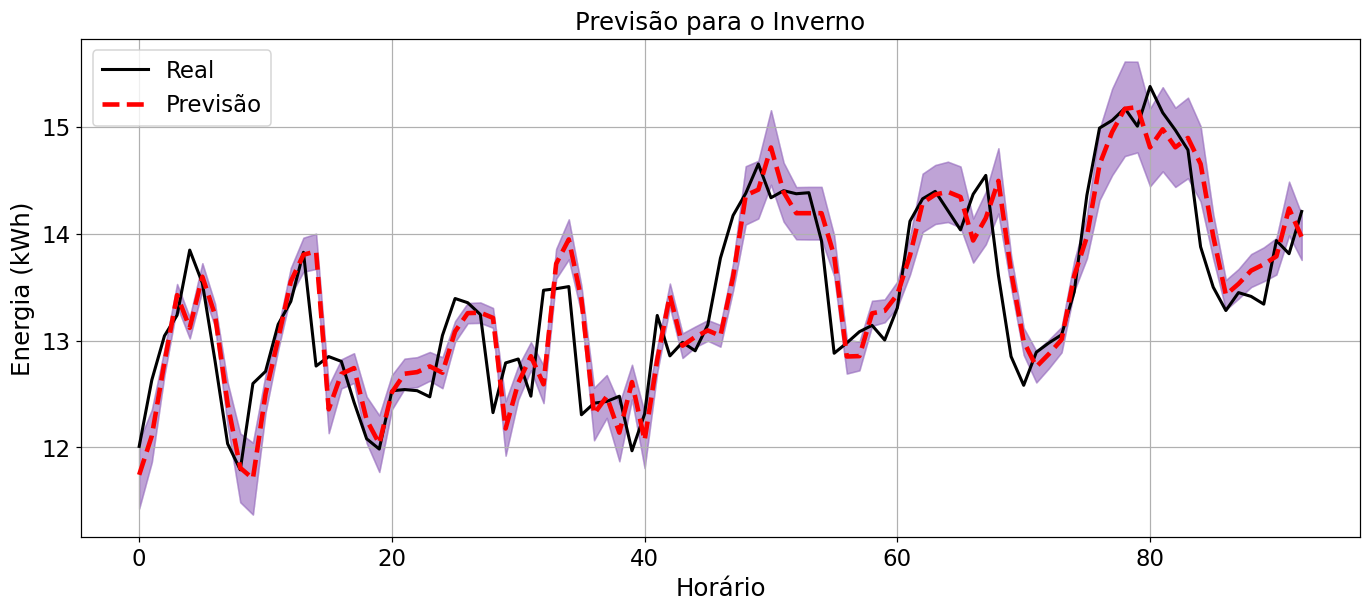

In [114]:
if freq == 'D':

  inverno_mu = inverno_mu1['2020-06-21':'2020-09-21']
  inverno_sigma = inverno_sigma1['2020-06-21':'2020-09-21']
  inverno_original = inverno_original['2020-06-21':'2020-09-21']
  t = np.arange(inverno_original.shape[0])

  fig_incerteza = plt.figure(figsize=(15,6),dpi=110)
  plt.plot(t,inverno_original, color="black", label="Real", lw=2)

  if altera_param == 'n':
    plt.plot(t,inverno_mu, '--', color='red', label="Previsão", lw=3)

    inverno_sigma = np.array(inverno_sigma)
    inverno_mu = np.array(inverno_mu)
    for shade in range(1,5):
      plt.fill_between(t, inverno_mu[:,0]+inverno_sigma[:,0], inverno_mu[:,0]-inverno_sigma[:,0], 
                      alpha=0.2, color='C4')


  plt.tick_params(axis='both', labelsize=15)
  plt.xlabel('Dias',fontsize=16)
  plt.ylabel('Potência (kWh)',fontsize=16)
  plt.legend(['Dado Estimado','Dado Real'])
  plt.title('Previsão para o Inverno',fontsize=16)
  plt.grid()
  plt.legend(fontsize=15)

  if altera_param == 'y':
    for k in range(0,len(line_types)):
      plt.plot(t,inverno_mu['2020-06-21':'2020-09-21'][k],line_types[k],color = line_colors[k],lw=3)

    if parameter == 1:
      leg1 = plt.legend(['Real','Previsão para l = 0.001','Previsão para l = 0.01',
                        'Previsão para l = 0.1','Previsão para l = 1','Previsão para l = 10'])
    elif parameter == 2:
      leg1 = plt.legend(['Real','Previsão para p=10%','Previsão para p=20%',
                      'Previsão para p=30%','Previsão para p=40%','Previsão para p=50%','Previsão para p=60%','Previsão para p=70%','Previsão para p=80%'])
    elif parameter == 3:
      leg1 = plt.legend(['Real','Previsão para peso = 1e-6','Previsão para peso = 1e-5',
                        'Previsão para peso = 1e-4','Previsão para peso = 1e-3','Previsão para peso = 1e-2'])
    
    inverno_sigma = np.array(inverno_sigma)
    inverno_mu = np.array(inverno_mu)
    for shade in range(0,len(line_types)):
      i = 1/(1+shade)
      if parameter == 2:
        plt.fill_between(t,inverno_mu[:,shade]+inverno_sigma[:,shade],inverno_mu[:,shade]-inverno_sigma[:,shade], 
                        alpha=i, color='C4',label='Incerteza para {}%'.format((shade+1)*10))
        
      elif parameter == 3:
        plt.fill_between(t,inverno_mu[:,shade]+inverno_sigma[:,shade],inverno_mu[:,shade]-inverno_sigma[:,shade], 
                        alpha=i, color='C4',label='Incerteza para peso = 1e-{}'.format((len(lbd)-shade)))

      elif parameter == 1:
        plt.fill_between(t,inverno_mu[:,shade]+inverno_sigma[:,shade],inverno_mu[:,shade]-inverno_sigma[:,shade], 
                      alpha=i, color='C{}'.format(shade+1),label='Incerteza para l = {}'.format(l[shade]))

    plt.legend(loc='lower right')
    plt.gca().add_artist(leg1)  

  plt.xlabel('Horário')
  plt.ylabel('Energia (kWh)')
  plt.title('Previsão para o Inverno',fontsize=16)
  plt.grid(True)
  plt.show()



#####Primavera

In [115]:
primavera_mu1 = pred_data_hourly['2020-09-21':'2020-12-21']
primavera_sigma1 = sigma_data_hourly['2020-09-21':'2020-12-21']/1e3
primavera_original = data_hourly_plot_dp['original']['2020-09-21':'2020-12-21']/1e3

if altera_param == 'n':
  MAPE = keras.metrics.mean_absolute_percentage_error(primavera_original,primavera_mu1)
  MAE = keras.metrics.mean_absolute_error(primavera_original,primavera_mu1)
  MSE = keras.metrics.mean_squared_error(primavera_original,primavera_mu1)
  sMAPE = sMAPE_fn(np.array(primavera_original),np.array(primavera_mu1))

  print('RMSE Primavera: ', np.sqrt(np.mean(MSE)))
  print('MAE Primavera: ', np.mean(MAE))
  print(f'MAPE Primavera: {np.mean(MAPE)} %')
  print(f'sMAPE Primavera: {np.mean(sMAPE)} %')

RMSE Primavera:  1.6368345
MAE Primavera:  1.3200991
MAPE Primavera: 9.627935409545898 %
sMAPE Primavera: 438.69829689673145 %


In [116]:
if freq == 'H':
  primavera_mu = primavera_mu1['2020-10-22']
  primavera_sigma = primavera_sigma1['2020-10-22']
  primavera_original = primavera_original['2020-10-22']

  hr = np.array(primavera_original.index.time)
  hr = [hr[i].strftime('%H:%M') for i in range(0,len(hr))]

  fig = plt.figure(figsize=(15,6),dpi=110)
  plt.xticks(np.arange(0, len(hr)+1, 3))
  plt.plot(hr,primavera_original['2020-10-22'],'black')

  if altera_param == 'n':
    plt.plot(hr,primavera_mu['2020-10-22'],'r--')
    
    primavera_mu = np.array(primavera_mu)
    primavera_sigma = np.array(primavera_sigma)

    for shade in range(0,len(line_types)):
      plt.fill_between(hr,primavera_mu[:,0]+primavera_sigma[:,0],primavera_mu[:,0]-primavera_sigma[:,0]
                       ,alpha=0.2, color='C4')


  if altera_param == 'y':
    for k in range(0,len(line_types)):
      plt.plot(hr,primavera_mu['2020-10-22'][k],line_types[k],color = line_colors[k],lw=3)

    if parameter == 1:
      leg1 = plt.legend(['Real','Previsão para l = 0.001','Previsão para l = 0.01',
                        'Previsão para l = 0.1','Previsão para l = 1','Previsão para l = 10'])
    elif parameter == 2:
      leg1 = plt.legend(['Real','Previsão para p=10%','Previsão para p=20%',
                      'Previsão para p=30%','Previsão para p=40%','Previsão para p=50%'])
    elif parameter == 3:
      leg1 = plt.legend(['Real','Previsão para peso = 1e-6','Previsão para peso = 1e-5',
                        'Previsão para peso = 1e-4','Previsão para peso = 1e-3','Previsão para peso = 1e-2'])

    primavera_sigma = np.array(primavera_sigma)
    primavera_mu = np.array(primavera_mu)

    for shade in range(0,len(line_types)):
      i = 1/(1+shade)
      if parameter == 2:
        plt.fill_between(hr,primavera_mu[:,shade]+primavera_sigma[:,shade],primavera_mu[:,shade]-primavera_sigma[:,shade],
                        alpha=i, color='C4',label='Incerteza para {}%'.format((shade+1)*10))
        
      elif parameter == 3:
        plt.fill_between(hr,primavera_mu[:,shade]+primavera_sigma[:,shade],primavera_mu[:,shade]-primavera_sigma[:,shade],
                        alpha=i, color='C4',label='Incerteza para peso = 1e-{}'.format((len(lbd)-shade)))

      elif parameter == 1:
        plt.fill_between(hr,primavera_mu[:,shade]+primavera_sigma[:,shade],primavera_mu[:,shade]-primavera_sigma[:,shade],
                      alpha=i, color='C{}'.format(shade+1),label='Incerteza para l = {}'.format(l[shade]))

    plt.legend(loc='upper left')
    plt.gca().add_artist(leg1)  

  plt.xlabel('Horário')
  plt.ylabel('Energia (kWh)')
  plt.title('Previsão para a Primavera',fontsize=16)
  plt.grid()
  plt.show()


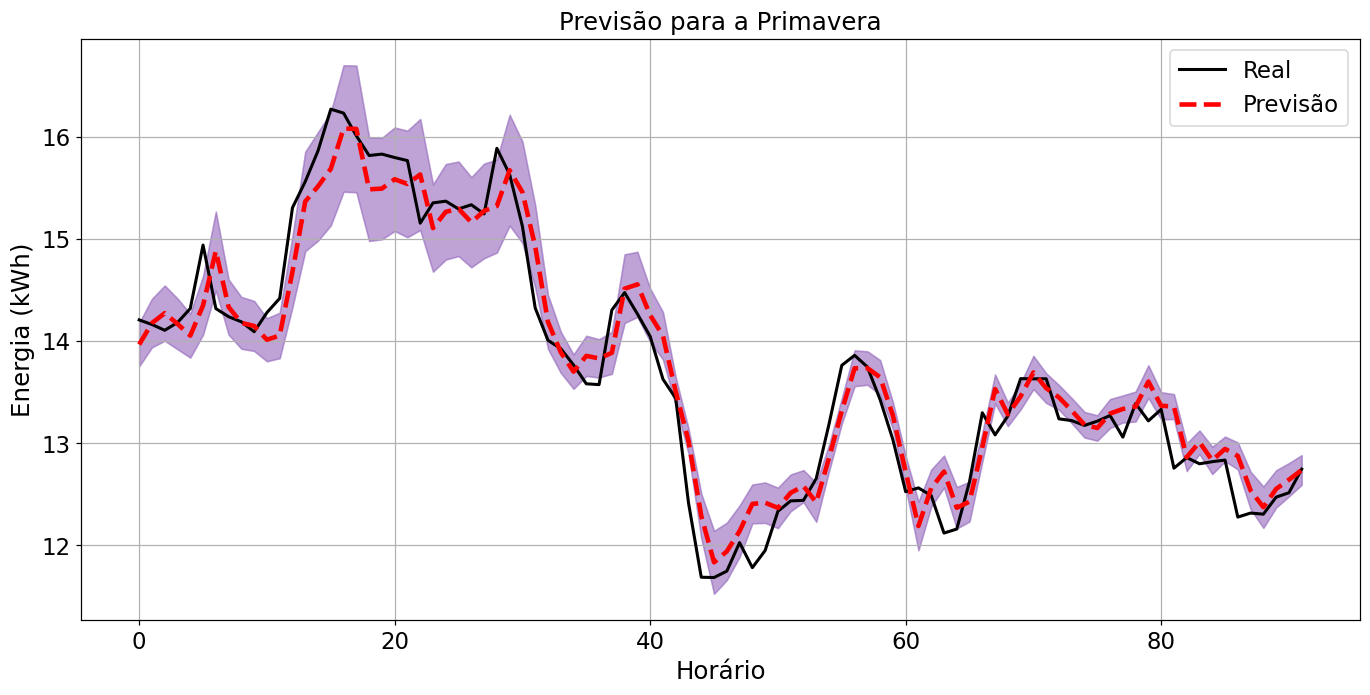

In [117]:
if freq == 'D':

  primavera_mu = primavera_mu1['2020-09-21':'2020-12-21']
  primavera_sigma = primavera_sigma1['2020-09-21':'2020-12-21']
  primavera_original = primavera_original['2020-09-21':'2020-12-21']

  t = np.arange(primavera_original.shape[0])

  fig_incerteza = plt.figure(figsize=(15,7),dpi=110)
  plt.plot(t,primavera_original, color="black", label="Real", lw=2)

  if altera_param == 'n':
    plt.plot(t,primavera_mu, '--', color='red', label="Previsão", lw=3)
    primavera_sigma = np.array(primavera_sigma)
    primavera_mu = np.array(primavera_mu)

    for shade in range(1,5):
      plt.fill_between(t, primavera_mu[:,0]+primavera_sigma[:,0], 
                      primavera_mu[:,0]-primavera_sigma[:,0], alpha=0.2, color='C4')

    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel('Dias',fontsize=16)
    plt.ylabel('Potência (kWh)',fontsize=16)
    plt.legend(['Dado Estimado','Dado Real'])
    plt.title('Previsão para a Primavera',fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=15)

  if altera_param == 'y':
    for k in range(0,len(line_types)):
      plt.plot(t,primavera_mu['2020-09-21':'2020-12-21'][k],line_types[k],color = line_colors[k],lw=3)

    if parameter == 1:
      leg1 = plt.legend(['Real','Previsão para l = 0.001','Previsão para l = 0.01',
                        'Previsão para l = 0.1','Previsão para l = 1','Previsão para l = 10'])
    elif parameter == 2:
      leg1 = plt.legend(['Real','Previsão para p=10%','Previsão para p=20%',
                      'Previsão para p=30%','Previsão para p=40%','Previsão para p=50%'])
    elif parameter == 3:
      leg1 = plt.legend(['Real','Previsão para peso = 1e-6','Previsão para peso = 1e-5',
                        'Previsão para peso = 1e-4','Previsão para peso = 1e-3','Previsão para peso = 1e-2'])

    primavera_sigma = np.array(primavera_sigma)
    primavera_mu = np.array(primavera_mu)

    for shade in range(0,len(line_types)):
      i = 1/(1+shade)
      if parameter == 2:
        plt.fill_between(t,primavera_mu[:,shade]+primavera_sigma[:,shade],primavera_mu[:,shade]-primavera_sigma[:,shade],
                        alpha=i, color='C4',label='Incerteza para {}%'.format((shade+1)*10))
        
      elif parameter == 3:
        plt.fill_between(t,primavera_mu[:,shade]+primavera_sigma[:,shade],primavera_mu[:,shade]-primavera_sigma[:,shade],
                        alpha=i, color='C4',label='Incerteza para peso = 1e-{}'.format((len(lbd)-shade)))

      elif parameter == 1:
        plt.fill_between(t,primavera_mu[:,shade]+primavera_sigma[:,shade],primavera_mu[:,shade]-primavera_sigma[:,shade],
                      alpha=i, color='C{}'.format(shade+1),label='Incerteza para l = {}'.format(l[shade]))

    plt.legend(loc='lower left')
    plt.gca().add_artist(leg1)  

  plt.xlabel('Horário')
  plt.ylabel('Energia (kWh)')
  plt.title('Previsão para a Primavera',fontsize=16)
  plt.grid(True)
  plt.show()


####Resultados de predição

In [118]:
if altera_param =='n':
  print('predição verão = {} kW'.format(round(pred_data_hourly[0]['2021-02-09'].sum(),2)))
  print('original verão = {} kW'.format(round(data_hourly_plot_dp['original']['2021-02-08'].sum(),2)))

  print('predição outono = {} kW'.format(round(pred_data_hourly[0]['2020-05-25'].sum(),2)))
  print('original outono = {} kW'.format(round(data_hourly_plot_dp['original']['2020-05-25'].sum(),2)))

  print('predição primavera = {} kW'.format(round(pred_data_hourly[0]['2020-10-22'].sum(),2)))
  print('original primavera = {} kW'.format(round(data_hourly_plot_dp['original']['2020-10-22'].sum(),2)))

  print('predição inverno = {} kW'.format(round(pred_data_hourly[0]['2020-06-25'].sum(),2)))
  print('original inverno = {} kW'.format(round(data_hourly_plot_dp['original']['2020-06-25'].sum(),2)))

predição verão = 14.0600004196167 kW
original verão = 14658.86 kW
predição outono = 12.729999542236328 kW
original outono = 12908.16 kW
predição primavera = 14.930000305175781 kW
original primavera = 14325.33 kW
predição inverno = 13.119999885559082 kW
original inverno = 13846.16 kW


In [119]:
round(data_hourly_plot_dp['original']['2020-05-25'].sum()/1e3,2)

12.91

In [120]:

print('incerteza maxima verão = {} kW'.format(verao_sigma.max()))
#print('incerteza media verão = {} kW'.format(verao_sigma.mean()))

print('incerteza maxima outono = {} kW'.format(outono_sigma.max()))
#print('incerteza media outono = {} kW'.format(outono_sigma.mean()))

print('incerteza maxima primavera = {} kW'.format(primavera_sigma.max()))
#print('incerteza media primavera = {} kW'.format(primavera_sigma.mean()))

print('incerteza maxima inverno = {} kW'.format(inverno_sigma.max()))
#print('incerteza media inverno = {} kW'.format(inverno_sigma.mean()))

incerteza maxima verão = 0.5678547620773315 kW
incerteza maxima outono = 0.5489792823791504 kW
incerteza maxima primavera = 0.6198804974555969 kW
incerteza maxima inverno = 0.4422551393508911 kW


In [121]:
print('incerteza maxima verão = {} kW'.format(verao_sigma1.max()))

incerteza maxima verão = 0    0.567855
dtype: float32 kW


In [122]:
print('incerteza maxima outono = {} kW'.format(outono_sigma1.max()))

incerteza maxima outono = 0    0.548979
dtype: float32 kW


In [123]:
print('incerteza maxima inverno = {} kW'.format(inverno_sigma1.max()))

incerteza maxima inverno = 0    0.442255
dtype: float32 kW


In [124]:
print('incerteza maxima primavera = {} kW'.format(primavera_sigma1.max()))

incerteza maxima primavera = 0    0.61988
dtype: float32 kW


In [125]:
idx = np.where(verao_sigma == verao_sigma.max())[0]
verao_mu_max  =  verao_mu[idx][0]

idx = np.where(outono_sigma == outono_sigma.max())[0]
outono_mu_max  =  outono_mu[idx][0]

idx = np.where(inverno_sigma == inverno_sigma.max())[0]
inverno_mu_max  =  inverno_mu[idx][0]

idx = np.where(primavera_sigma == primavera_sigma.max())[0]
primavera_mu_max  =  primavera_mu[idx][0]

In [126]:
inc_max_verao = 100*abs(verao_sigma.max()-verao_mu_max)/verao_sigma.max()
# inc_min_verao = 100*abs(verao_sigma.min()-verao_sigma.mean())/verao_sigma.min()

inc_max_outono = 100*abs(outono_sigma.max()-outono_mu_max)/outono_sigma.max()
# inc_min_outono = 100*abs(outono_sigma.min()-outono_sigma.mean())/outono_sigma.min()

inc_max_inverno = 100*abs(inverno_sigma.max()-inverno_mu_max)/inverno_sigma.max()
# inc_min_inverno = 100*abs(inverno_sigma.min()-inverno_sigma.mean())/inverno_sigma.min()

inc_max_primavera = 100*abs(primavera_sigma.max()-primavera_mu_max)/primavera_sigma.max()
# inc_min_primavera = 100*abs(primavera_sigma.min()-primavera_sigma.mean())/primavera_sigma.min()

print('incerteza maxima verão = {} %'.format(inc_max_verao/1e3))
# print('incerteza minima verão = {} %'.format(round(inc_min_verao/1e3,3)))

print('incerteza maxima outono = {} %'.format(inc_max_outono/1e3))
# print('incerteza minima outono = {} %'.format(round(inc_min_outono/1e3,3)))

print('incerteza maxima inverno = {} %'.format(inc_max_inverno/1e3))
# print('incerteza minima primavera = {} %'.format(round(inc_min_inverno/1e3,3)))

print('incerteza maxima primavera = {} %'.format(inc_max_primavera/1e3)) 
# print('incerteza minima inverno = {} %'.format(round(inc_min_primavera/1e3,3)))

incerteza maxima verão = [1.7397454] %
incerteza maxima outono = [1.8361602] %
incerteza maxima inverno = [3.3297575] %
incerteza maxima primavera = [2.4936874] %


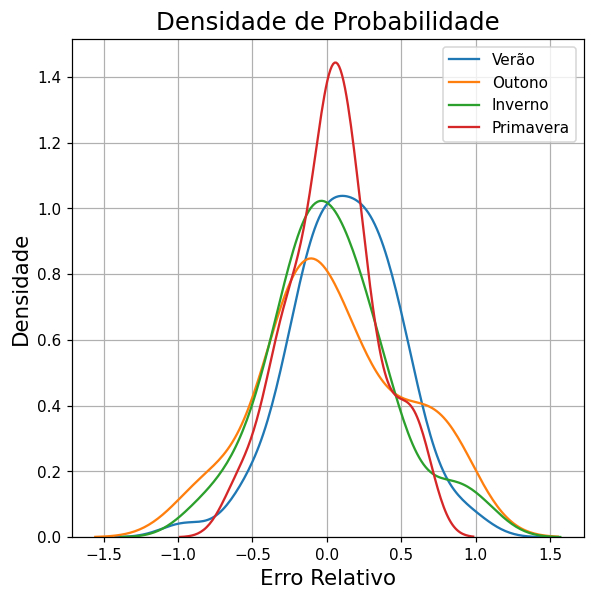

In [127]:
if altera_param == 'n':
  plt.figure(figsize=(6,6),dpi=110)
  plt.grid()
  sns.kdeplot(verao_mu[:,0]-verao_original)
  sns.kdeplot(outono_mu[:,0]-outono_original)
  sns.kdeplot(inverno_mu[:,0]-inverno_original)
  sns.kdeplot(primavera_mu[:,0]-primavera_original)
  plt.legend(['Verão','Outono','Inverno','Primavera'])
  plt.title('Densidade de Probabilidade',fontsize=16)
  plt.xlabel('Erro Relativo',fontsize=14)
  plt.ylabel('Densidade',fontsize=14)

In [128]:
pd.DataFrame(verao_mu).max()

0    15.064236
dtype: float32

In [129]:
pd.DataFrame(verao_sigma).max()

0    0.567855
dtype: float32